## Title: EDA and Feature Engineering
Author: Yiran Jing

Date: 11-07-2019


**DataSet description**
- OneStreamGolfData.csv
- weatherdata.csv
- Our target is **Amount** 
- Item_Id: **region**: we have **36** items
- Some regions have 2 years data (2010 and 2011), but more regions have 1 year data only (2011). also a few region has 1.5 years data


**Main Input DataSet requirment** (one-dimentional time series data set with three column) 
- **Item_id**: string, region
- **Target_value**: float, amount
- **timestamp**: timestamp, month

In [90]:
import boto3
import pandas as pd
import pyspark
from sagemaker import get_execution_role
import seaborn as sns
import numpy as np
import calendar
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, skew
import statsmodels.api as sm
blue = sns.color_palette('Blues')[-2]
color = sns.color_palette() 
sns.set_style('darkgrid') 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import nltk
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime

# Plot settings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
green='#A2CD5A'
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

from time_series_help_function import draw_time_series,draw_log_time_series,draw_acf_pacf

#### Load dataset

In [91]:
golf_data = 's3://taysolsdev/datasets/GolfDataforecast/OneStreamGolfData.csv'
golf_data = pd.read_csv(golf_data, encoding = "ISO-8859-1")

In [92]:
weather_data = 's3://taysolsdev/datasets/GolfDataforecast/weatherdata.csv'
weather_data = pd.read_csv(weather_data, encoding = "ISO-8859-1")

## Clean Data
- convert column name to all lower cases
- strip the leading space for columns
#### Rename columns
- rename 'ud3' to 'region', same as the column name in weather data.
- rename 'time' to 'month', same as the column name in weather data.
- rename 'ud2' to 'product'
- rename 'ud4' to 'retailer'
- remove space in the column entry 
#### Delete unnecessary columns
- delete the columns if nan values only
- delete the columns if no missing value and just one value within that column, since this kind of column give us no useful info for modelling

In [93]:
# initial columns' name
golf_data.columns

Index(['Cube', ' Entity', ' Parent', ' Cons', ' Scenario', ' Time', ' View',
       ' Account', ' Flow', ' Origin', ' IC', ' UD1', ' UD2', ' UD3', ' UD4',
       ' UD5', ' UD6', ' UD7', ' UD8', ' Amount', ' HasData', ' Annotation',
       ' Assumptions', ' AuditComment', ' Footnote', ' VarianceExplanation'],
      dtype='object')

In [94]:
# initial columns' name
weather_data.columns

Index(['Region', 'Month', 'High ', 'Low', 'RainFall', 'Snowfall',
       'Daylight Hours'],
      dtype='object')

In [95]:
# change column name to all lower cases
golf_data = golf_data.rename(str.lower, axis='columns')
weather_data = weather_data.rename(str.lower, axis='columns')

In [96]:
for column_name in golf_data.columns:
    clean_column = column_name.replace(" ","") # strip the leading space for columns
    golf_data[clean_column] = golf_data[column_name]
    del golf_data[column_name] # delete the old column

In [97]:
# rename 'UD3' to 'region', same as the column name in weather data.
golf_data = golf_data.rename(index=str, columns={"ud3": "region"})
# rename 'time' to 'month', same as the column name in weather data
golf_data = golf_data.rename(index=str, columns={"time": "month"})
# rename 'UD2' to 'product'
golf_data = golf_data.rename(index=str, columns={"ud2": "product"})
# rename 'UD4' to 'retailer'
golf_data = golf_data.rename(index=str, columns={"ud4": "retailer"})
# remove space in the column entry
golf_data['retailer'] = golf_data['retailer'].str.replace(' ', '')

### Remove unnecessary columns
- delete the columns if nan values only
- delete the columns if no missing value and just one value within that column, since this kind of column give us no useful info for modelling

In [98]:
print ("\nUnique values :  \n", golf_data.nunique())


Unique values :  
 entity                     2
parent                     0
cons                       1
scenario                   2
month                     24
view                       1
account                    2
flow                       1
origin                     1
ic                         1
ud1                        1
product                   19
region                    36
retailer                  18
ud5                        1
ud6                        1
ud7                        1
ud8                        1
amount                 14826
hasdata                    1
annotation                 0
assumptions                0
auditcomment               0
footnote                   0
varianceexplanation        0
dtype: int64


In [99]:
golf_data['parent'].unique()

array([nan])

From the list above, we can see there are nan values only in annotation, assumptions, auditcomment, footnote, varianceexplanation and parent, Thus we delete these columns.

In [100]:
# delete the column since no information in it
del golf_data['annotation']
del golf_data['assumptions']
del golf_data['auditcomment']
del golf_data['footnote']
del golf_data['varianceexplanation']
del golf_data['parent']

In [101]:
# check if still missing value here
golf_data.isnull().sum()

entity      0
cons        0
scenario    0
month       0
view        0
account     0
flow        0
origin      0
ic          0
ud1         0
product     0
region      0
retailer    0
ud5         0
ud6         0
ud7         0
ud8         0
amount      0
hasdata     0
dtype: int64

From list above, we can see no missing value

In [102]:
golf_data['hasdata'].unique()

array(['Yes'], dtype=object)

In [103]:
# delete the columns if no missing value and just one value within that column
# since this kind of column give us no useful info for modelling
del golf_data['cons']
del golf_data['view']
del golf_data['flow']
del golf_data['origin']
del golf_data['ic']
del golf_data['ud1']
del golf_data['ud5']
del golf_data['ud6']
del golf_data['ud7']
del golf_data['ud8']
del golf_data['hasdata']

From the cell result below, we can see we entity, scenario and account are **binary variable**.

In [104]:
for column in golf_data:
    print(column)
    print(golf_data[column].unique())
    print("----------------")

entity
['Houston Heights' 'South Houston']
----------------
scenario
['Actual' 'BudgetV1']
----------------
month
['2010M1' '2010M2' '2010M3' '2010M4' '2010M5' '2010M6' '2010M7' '2010M8'
 '2010M9' '2010M10' '2010M11' '2010M12' '2011M1' '2011M2' '2011M3'
 '2011M4' '2011M5' '2011M6' '2011M7' '2011M8' '2011M9' '2011M10' '2011M11'
 '2011M12']
----------------
account
['2000_100' '2000_200']
----------------
product
['Mach5' 'Elite' 'Launcher' 'Mach10' 'Choker' 'Fat Boy' 'Hybrid SL'
 'Hybrid XF' 'Ice Man' 'Iron SL' 'Iron XF' 'Soft Touch' 'Thunder'
 'Ultimate XL' 'Wedge LT' 'Wedge XF' 'Wedges SL' 'Hybrid LT' 'Iron LT']
----------------
region
['Japan' 'SA' 'Midwest' 'Northeast' 'West' 'Europe' 'None' 'Southeast'
 'Canada' 'Southwest' 'Other NA' 'Mexico' 'Australia' 'Middle East'
 'South Korea' 'Other Asia' 'California' 'Florida' 'Georgia' 'Illinois'
 'Michigan' 'Nevada' 'Ohio' 'Oregon' 'Other Midwest' 'Other Southeast'
 'Other West' 'South Carolina' 'Connecticut' 'New Jersey' 'New York'
 'Ot

### Create new column called target, which is sum of amount for each region

In [105]:
final_trans = golf_data[['month','region','amount']].groupby(['month','region']).sum().reset_index(['month','region'])

In [106]:
final_trans.head()

month     region      amount
0  2010M1  Australia 1165742.039
1  2010M1     Canada  750215.244
2  2010M1     Europe 2746038.029
3  2010M1      Japan 2636650.760
4  2010M1     Mexico   91803.290

## EDA

From the cell below, we can see we have 36 regions in main dataset, but weather data only contain 28 regions.

In [107]:
print("number of regions in galf dataset(our main dataset): {}".format(len(final_trans['region'].unique())))
print("number of regions in weather dataset(the dataset we want to join): {}".format(len(weather_data['region'].unique())))
      

number of regions in galf dataset(our main dataset): 36
number of regions in weather dataset(the dataset we want to join): 28


From the cell below, we can see we two datasets have the same length of time series data. Thus we can use the full weather dataset to help forecast the golf data. 

2 years data

In [108]:
print("month in golf data: ")
print(final_trans['month'].unique())
print("month in weather data: ")
print(weather_data['month'].unique())

month in golf data: 
['2010M1' '2010M10' '2010M11' '2010M12' '2010M2' '2010M3' '2010M4'
 '2010M5' '2010M6' '2010M7' '2010M8' '2010M9' '2011M1' '2011M10' '2011M11'
 '2011M12' '2011M2' '2011M3' '2011M4' '2011M5' '2011M6' '2011M7' '2011M8'
 '2011M9']
month in weather data: 
['2010M1' '2010M2' '2010M3' '2010M4' '2010M5' '2010M6' '2010M7' '2010M8'
 '2010M9' '2010M10' '2010M11' '2010M12' '2011M1' '2011M2' '2011M3'
 '2011M4' '2011M5' '2011M6' '2011M7' '2011M8' '2011M9' '2011M10' '2011M11'
 '2011M12']


### Convert month column to timestamp: require for Amazon forecast

In [109]:
final_trans['month'] = final_trans['month'].str.replace('M10', '10')
final_trans['month'] = final_trans['month'].str.replace('M11', '11')
final_trans['month'] = final_trans['month'].str.replace('M12', '12')
final_trans['month'] = final_trans['month'].str.replace('M1', '01')
final_trans['month'] = final_trans['month'].str.replace('M2', '02')
final_trans['month'] = final_trans['month'].str.replace('M3', '03')
final_trans['month'] = final_trans['month'].str.replace('M4', '04')
final_trans['month'] = final_trans['month'].str.replace('M5', '05')
final_trans['month'] = final_trans['month'].str.replace('M6', '06')
final_trans['month'] = final_trans['month'].str.replace('M7', '07')
final_trans['month'] = final_trans['month'].str.replace('M8', '08')
final_trans['month'] = final_trans['month'].str.replace('M9', '09')

In [110]:
final_trans["month"][:len(final_trans)] =  pd.to_datetime(final_trans.month[:len(final_trans)], 
                                                          yearfirst = True, format='%Y%m')

final_trans = final_trans.sort_values(by="month")
# set month to index
final_trans.index = pd.DatetimeIndex(final_trans.month)
del final_trans["month"]

### Testing Assumptions of model: augmented Dickey fuller test

First part of classical time series model is that we require **stationarity** of the time series. We use the augmented Dickey fuller test. 

Recall that the null hypothesis is that we don't have a stationary time series, so a rejection suggests stationarity of the data. In other world, if p_value <0.01, we can say we have stationary data

from the result below, all regions have non-stationary data. **Thus we need to stationary data before train model**

In [111]:
from statsmodels.tsa.stattools import adfuller

products = final_trans.region.unique()
products_stationary = {} # collect stationary data: key is the name or product, value is p_value
products_nonstationary = {} # collect non-stationary data 


"""
Run ADF test on each product and check test.
"""
for prod in products:
    prod_df = final_trans[final_trans.region == prod]
    p_value = adfuller(prod_df['amount'])[1]
    if p_value <0.01:  # we do at the 1% comcident level.
        products_stationary[prod] = p_value
    else:
        products_nonstationary[prod] = p_value 
    #print("P-value for {} is {:.5f}".format(prod, adfuller(prod_df['amount'])[1]))
    

In [112]:
print("There are {} products with stationary data".format(len(products_stationary)))
print("There are {} products with non-stationary data".format(len(products_nonstationary)))


There are 0 products with stationary data
There are 36 products with non-stationary data


### Plot original data 

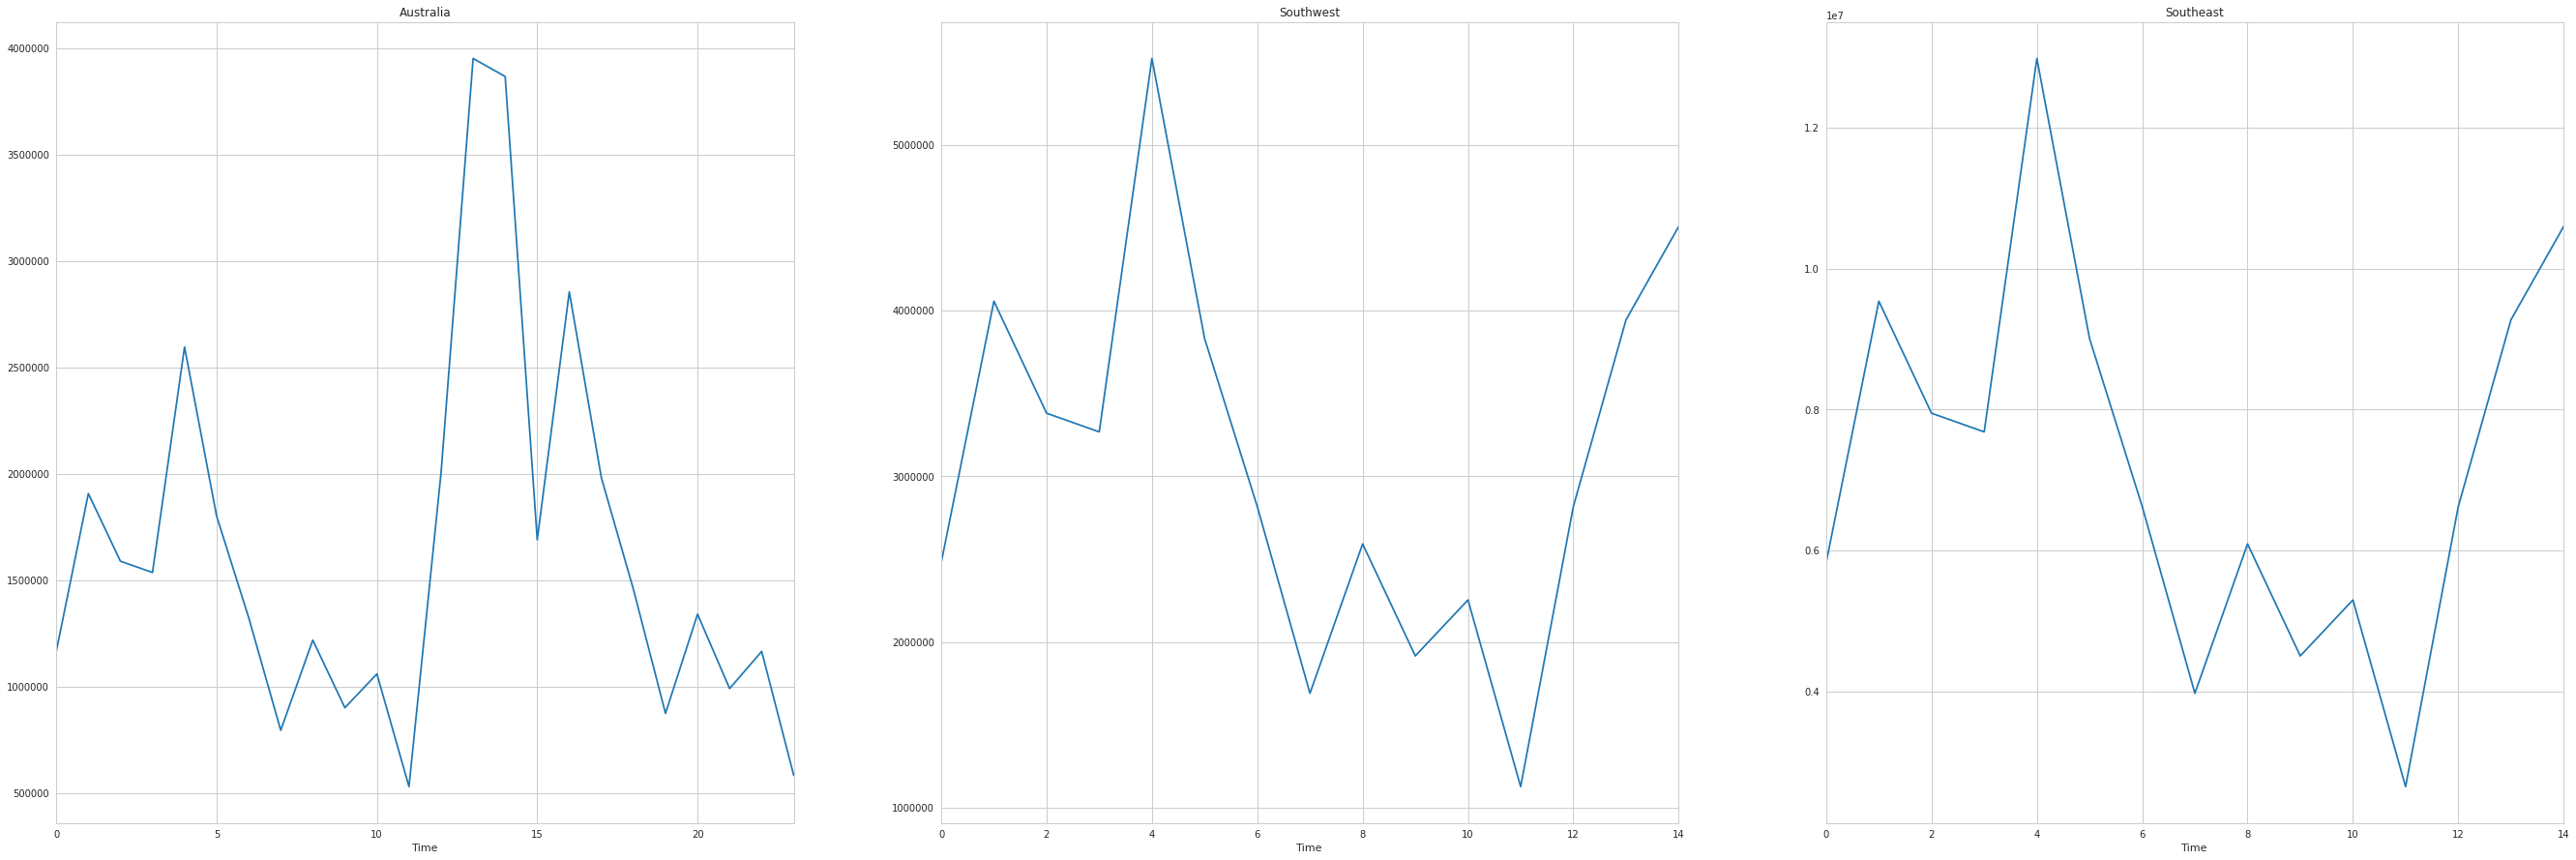

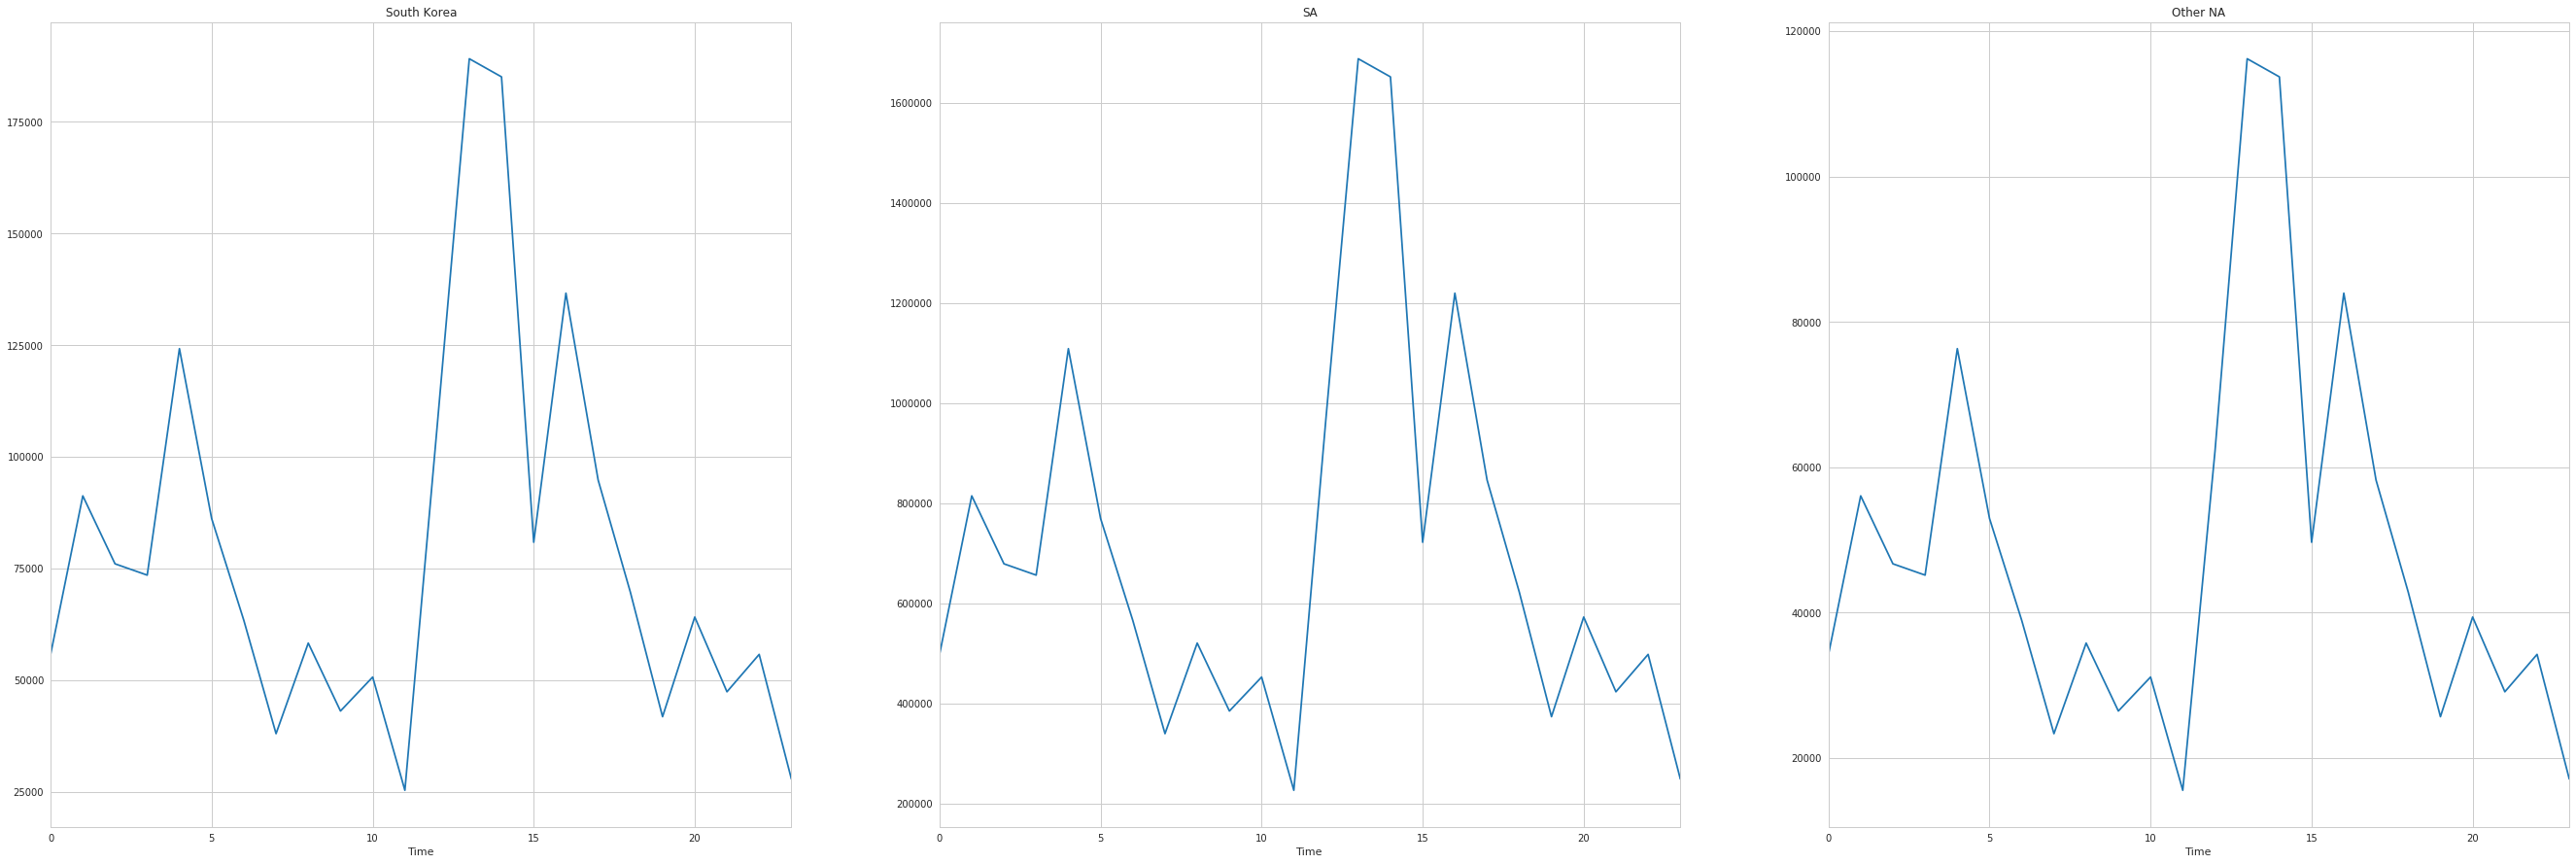

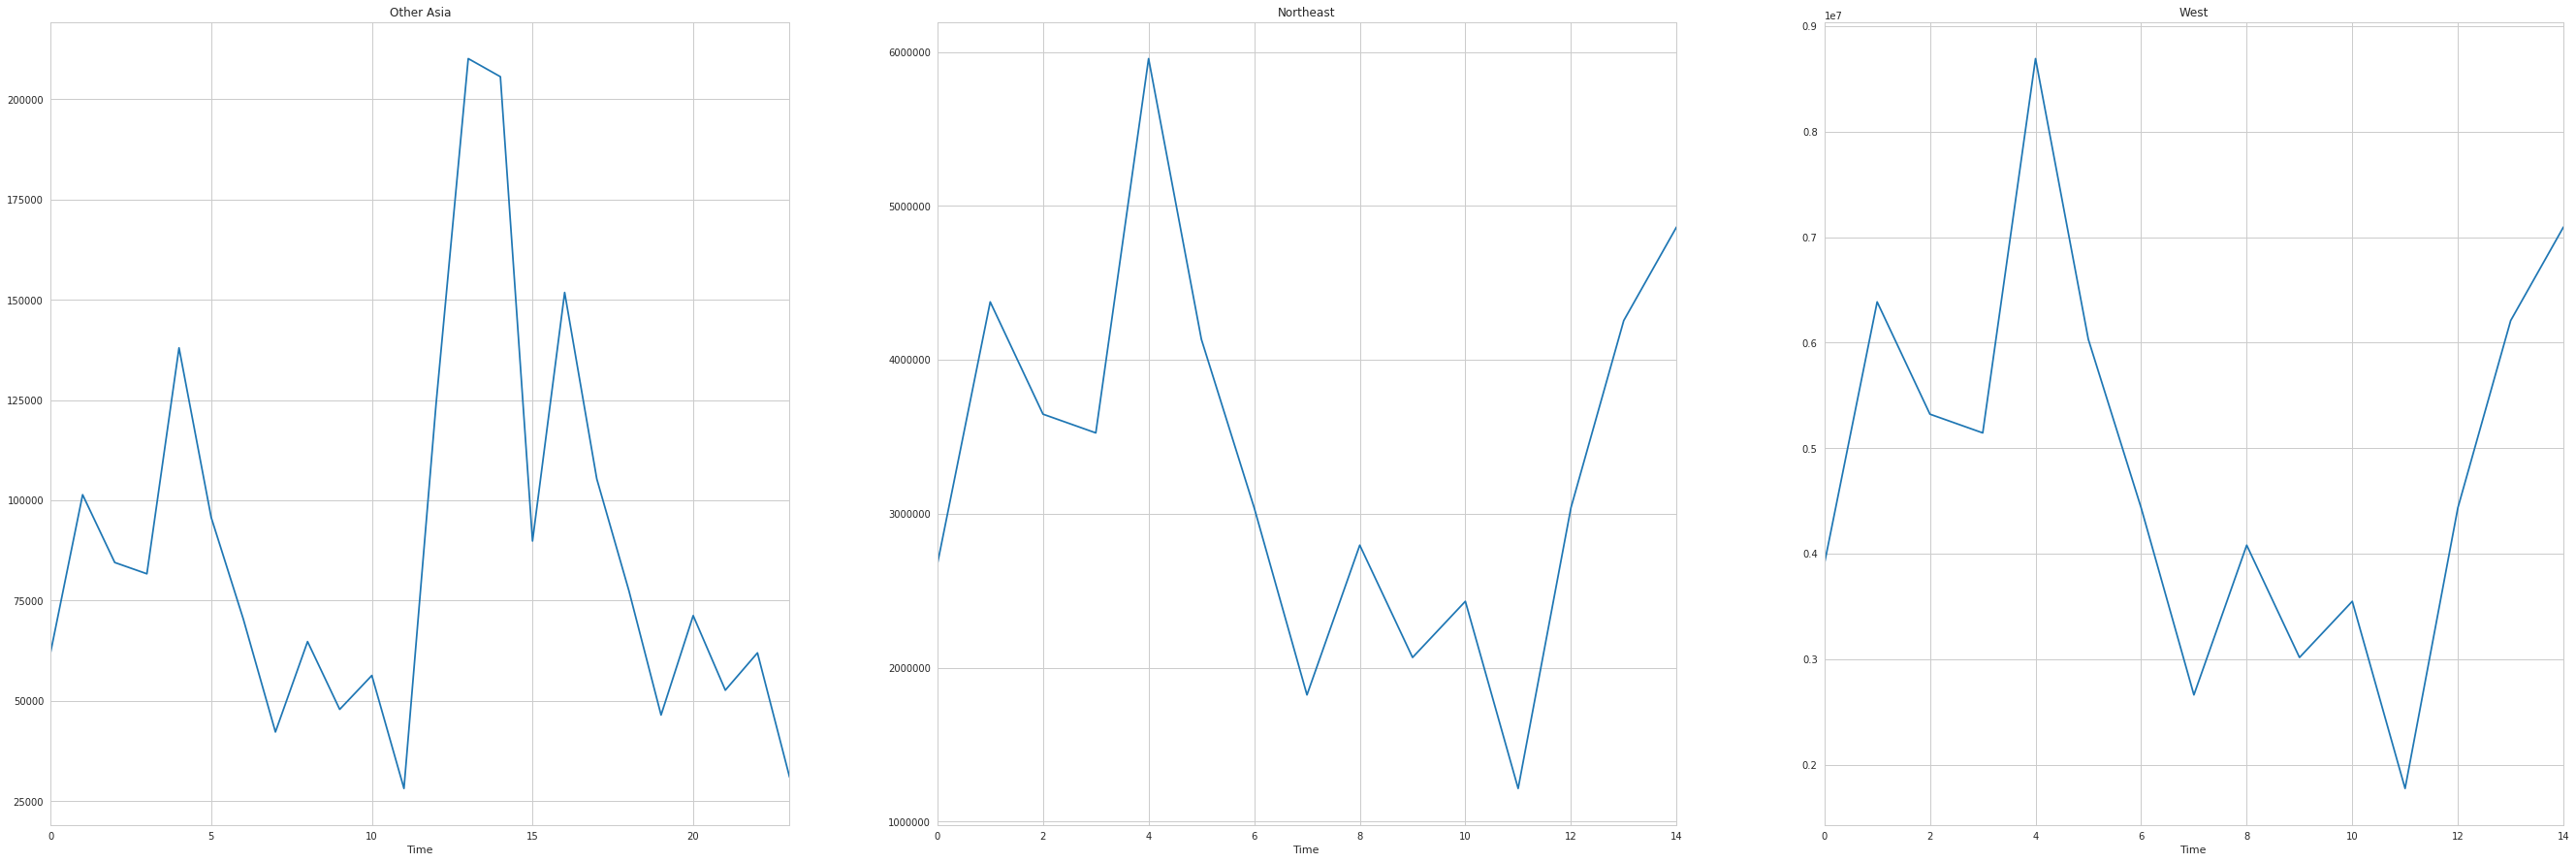

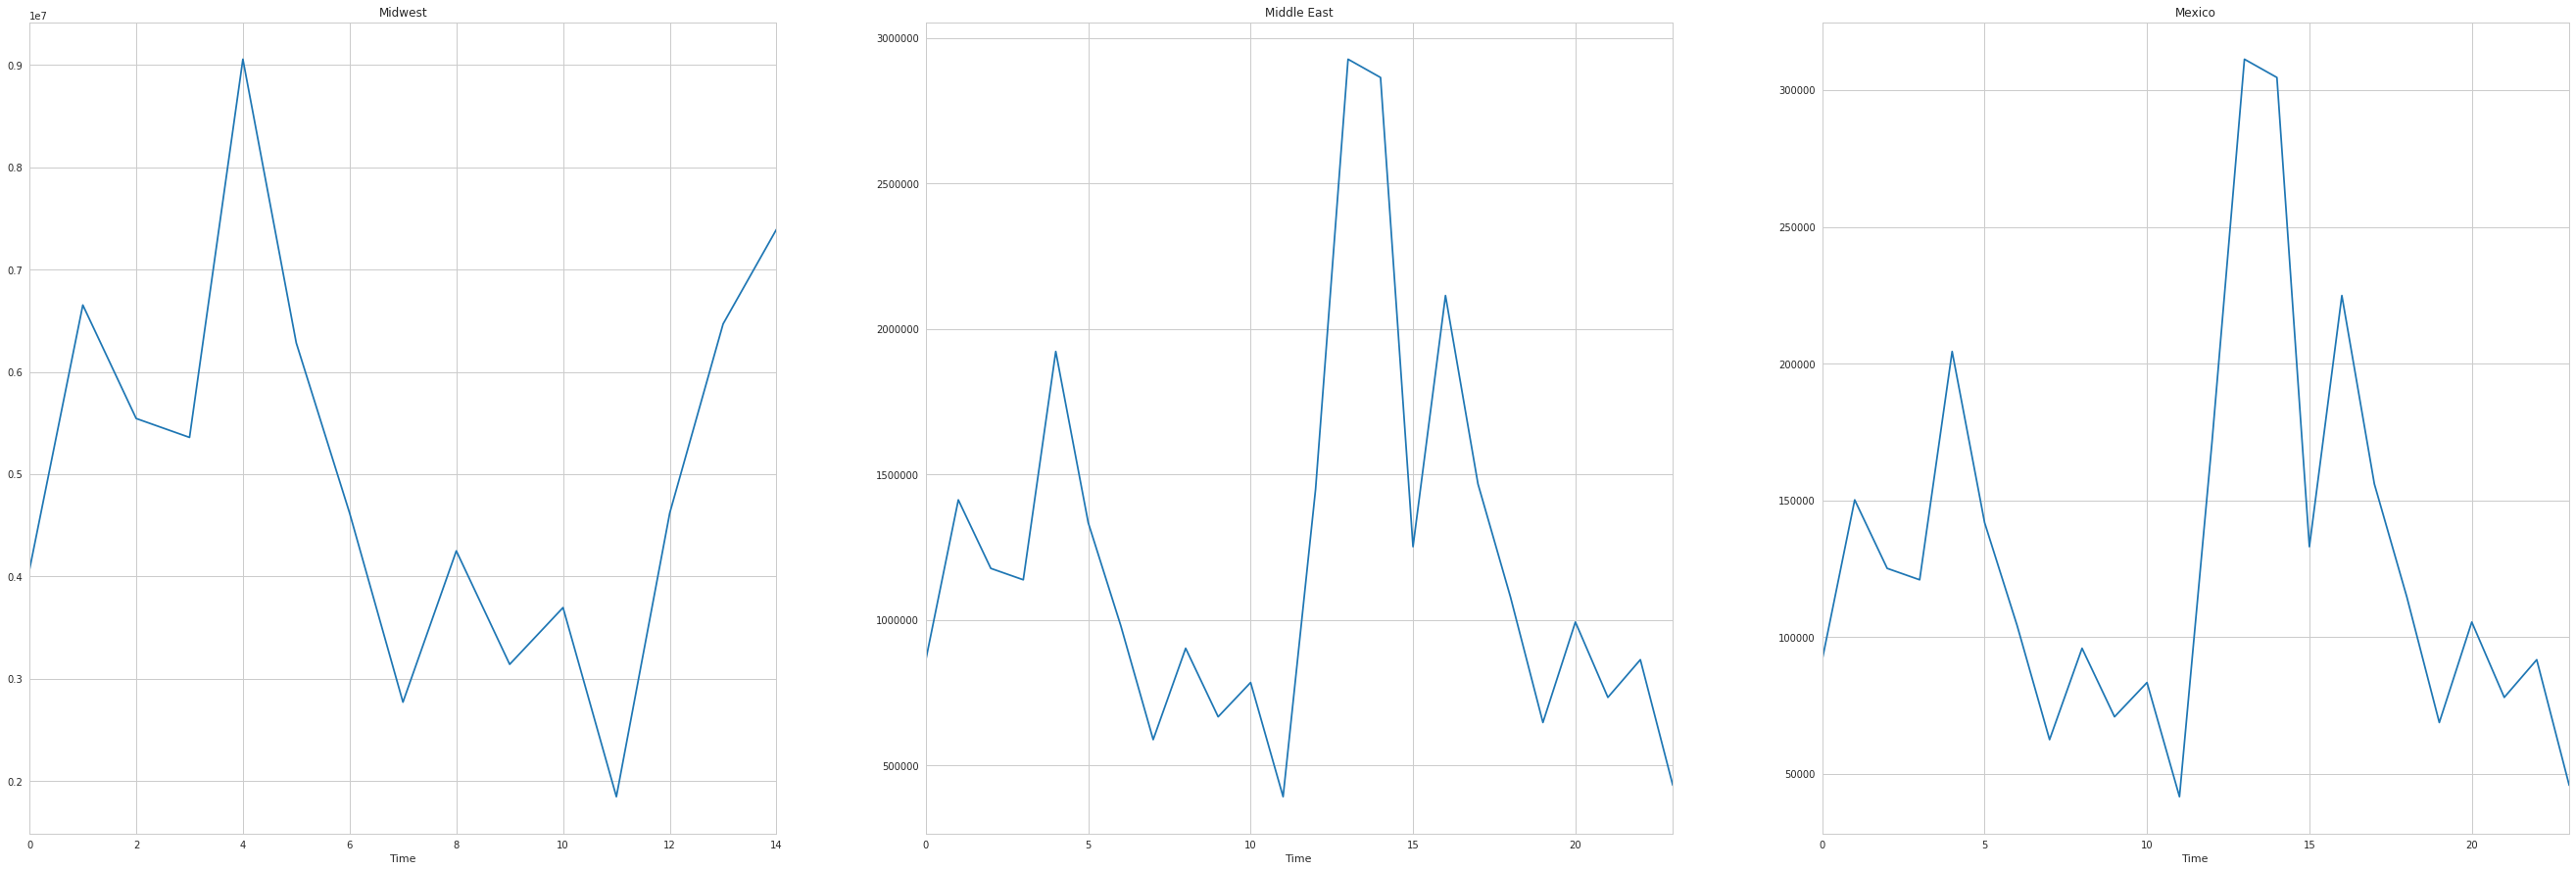

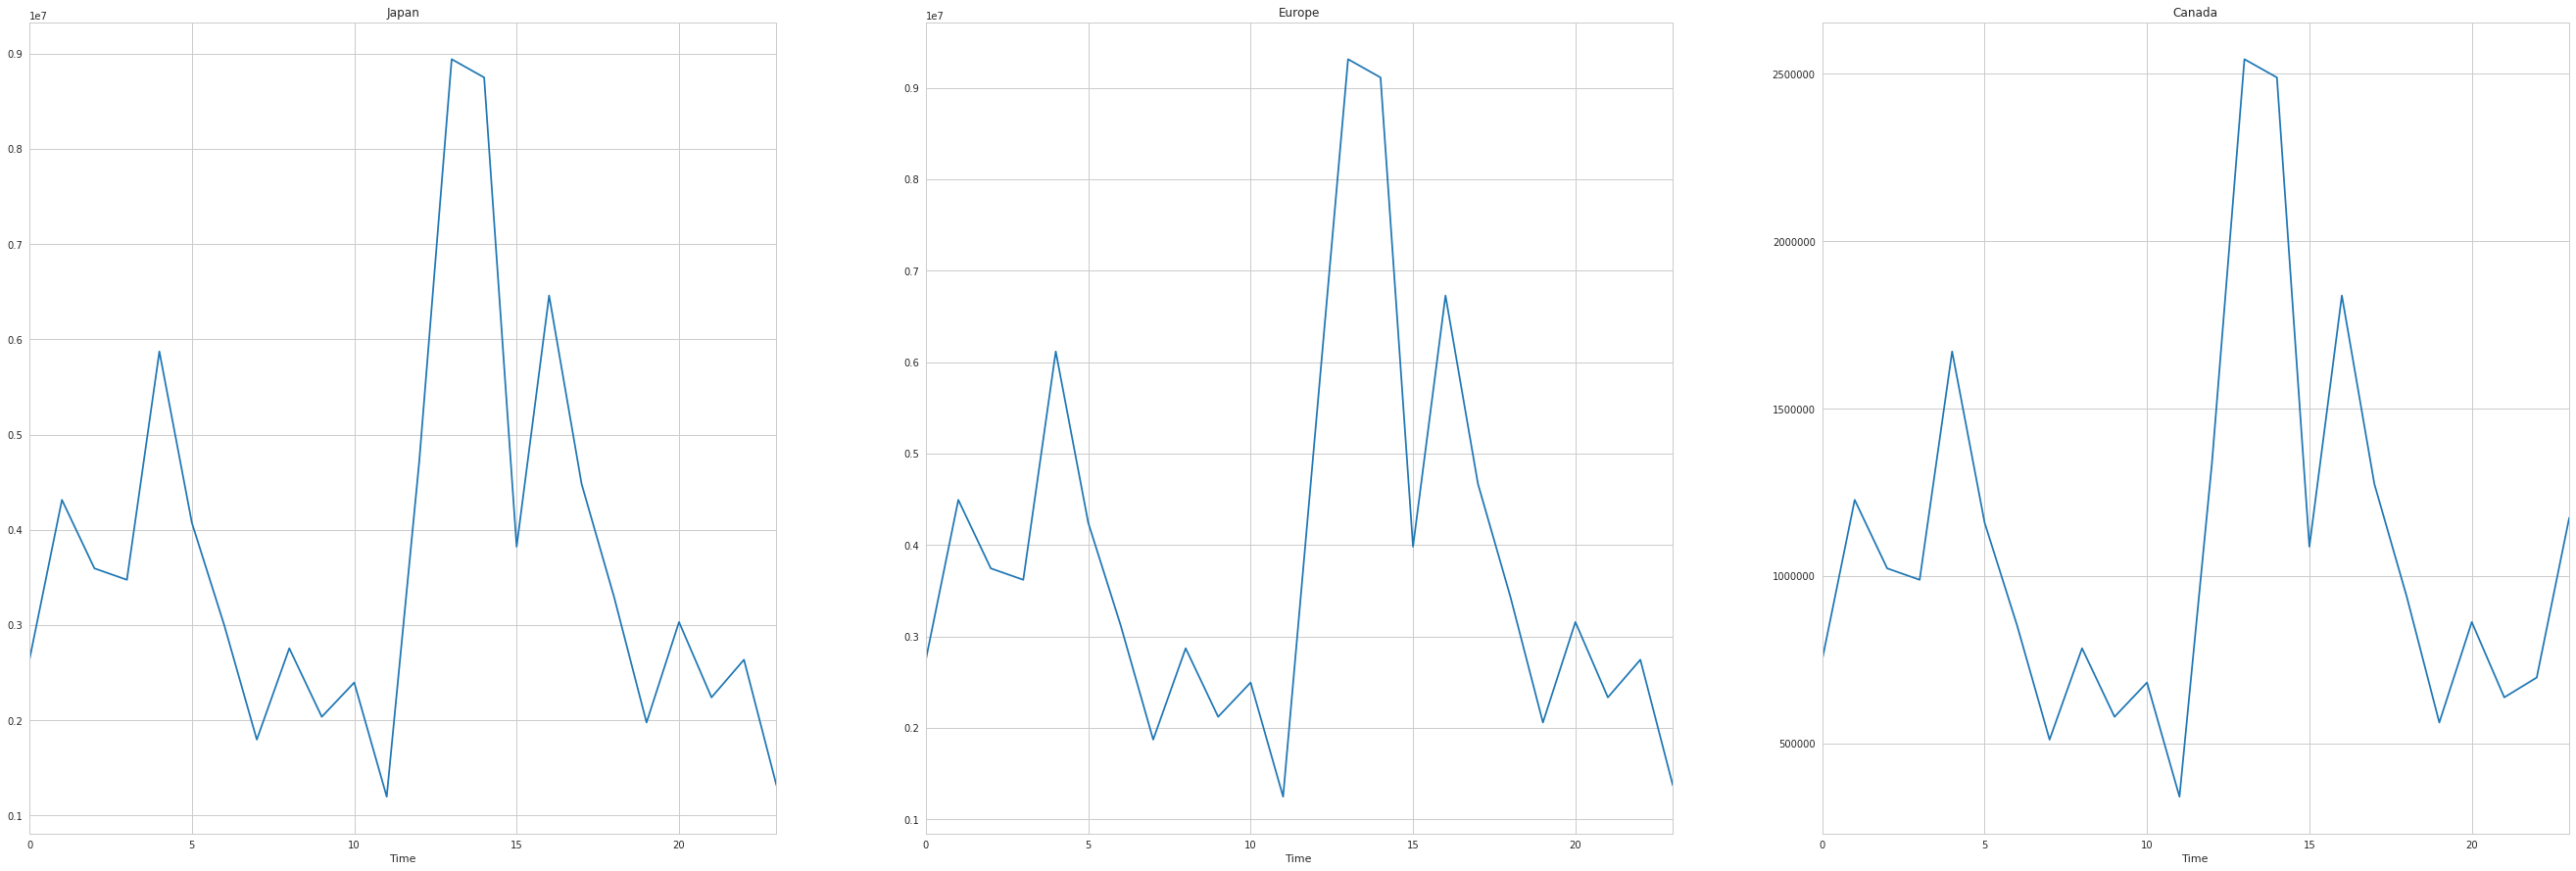

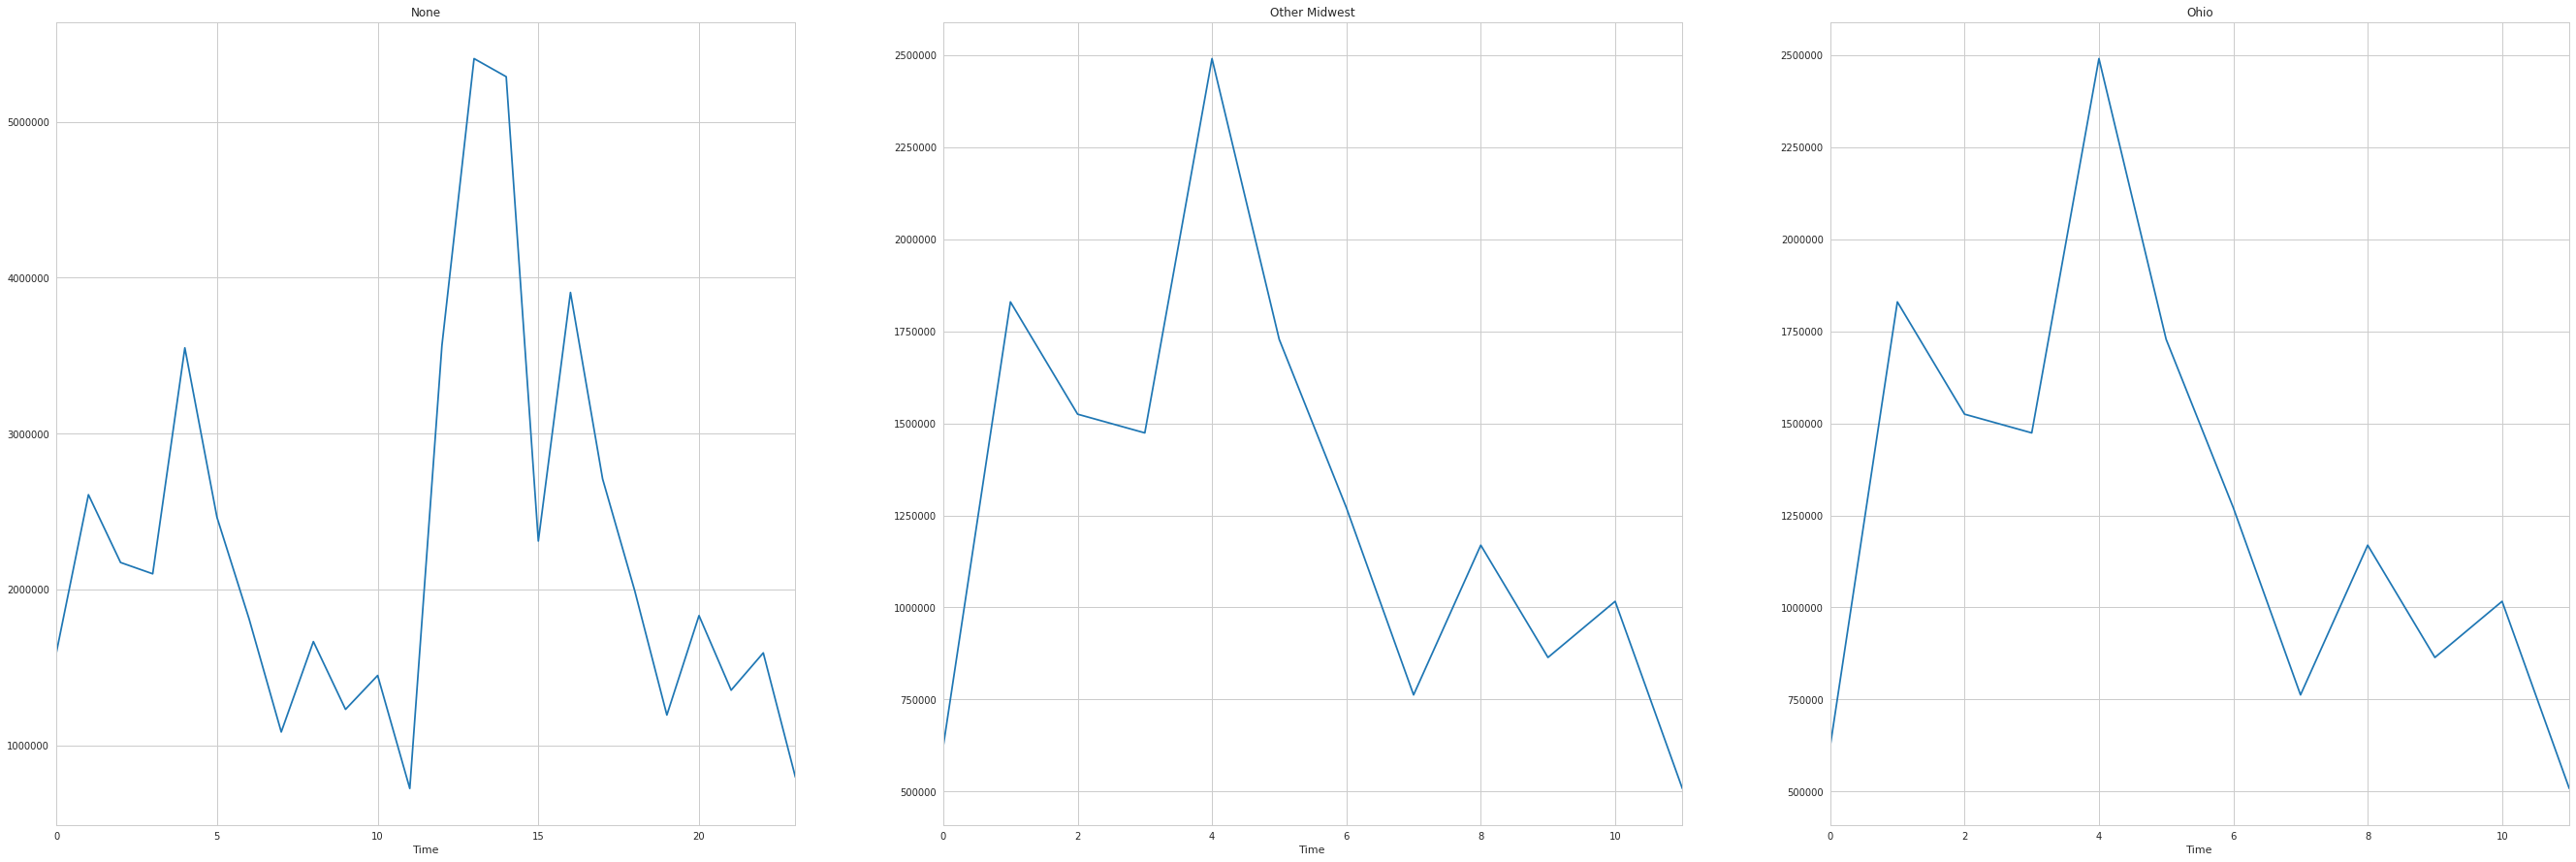

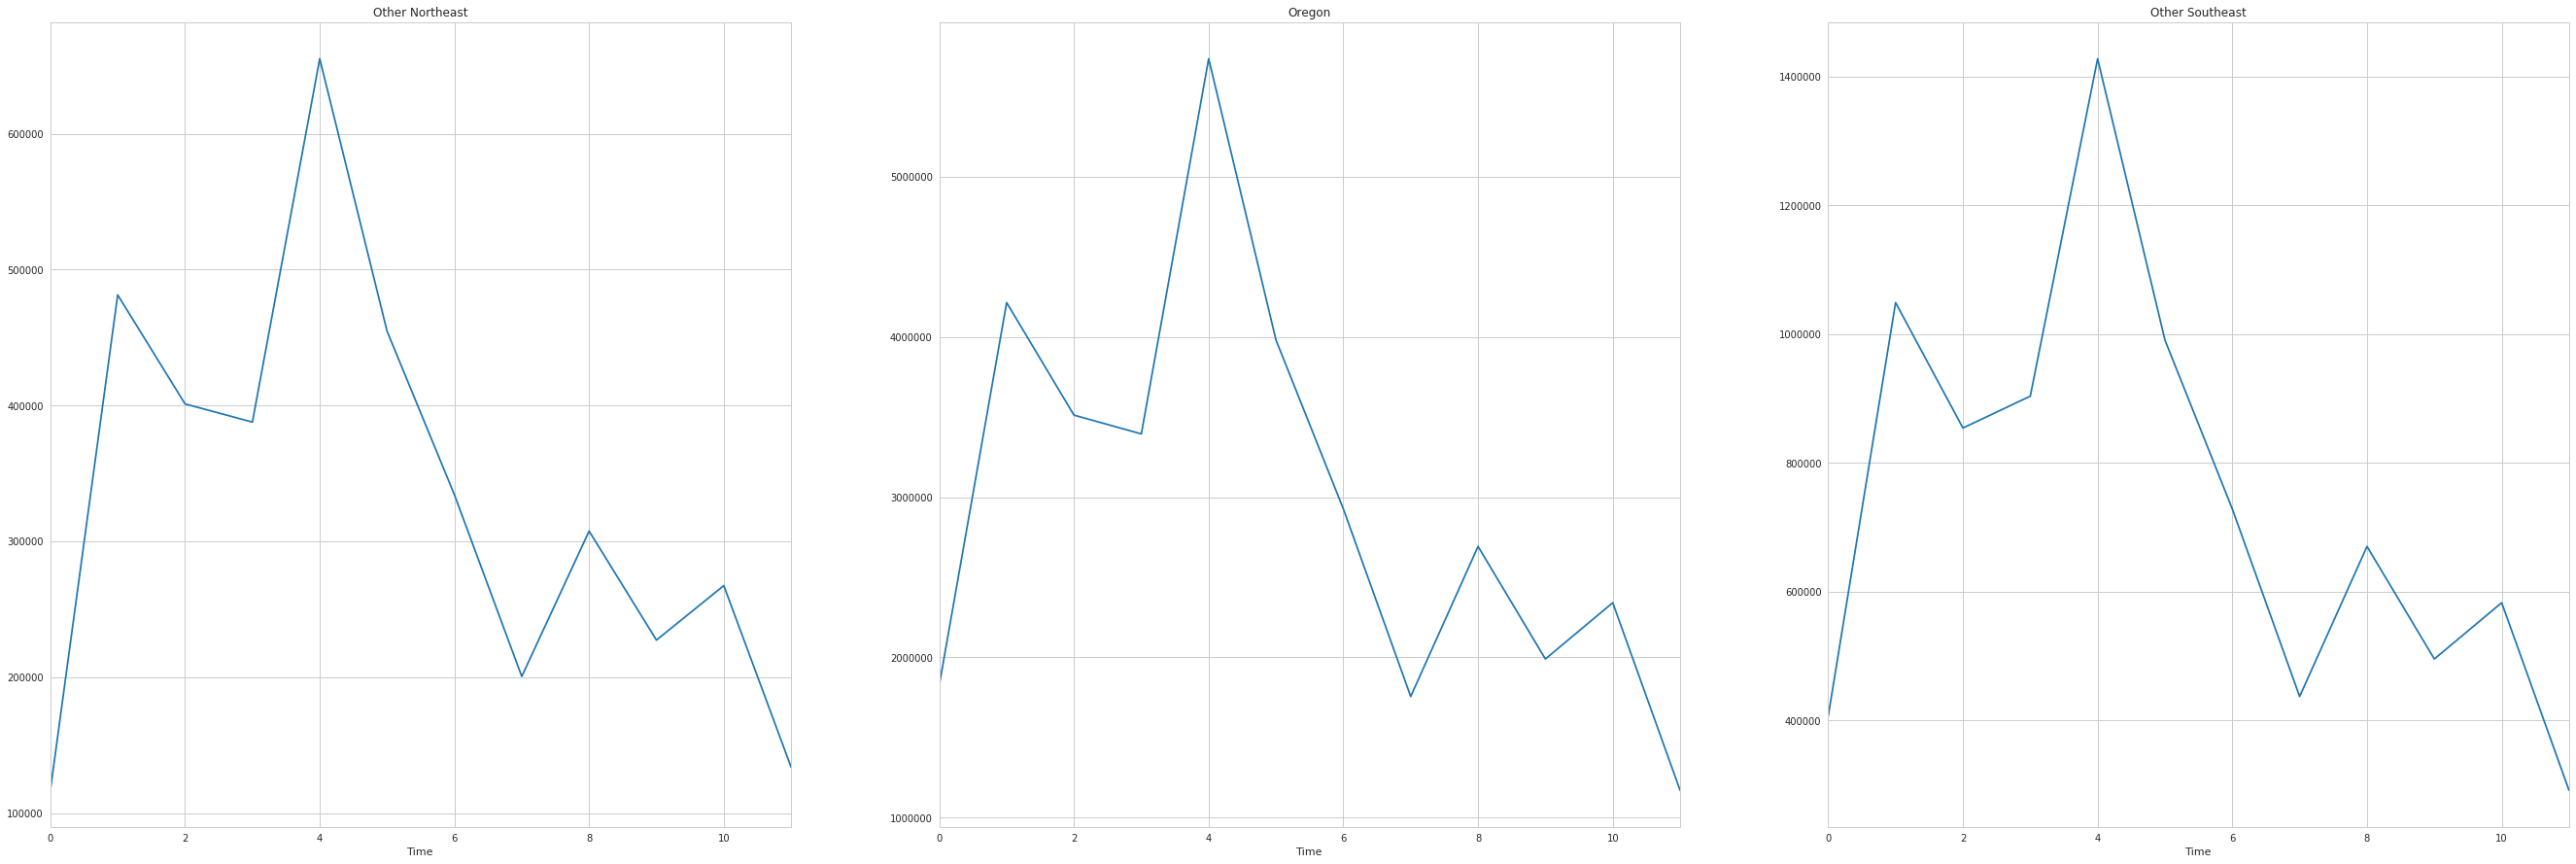

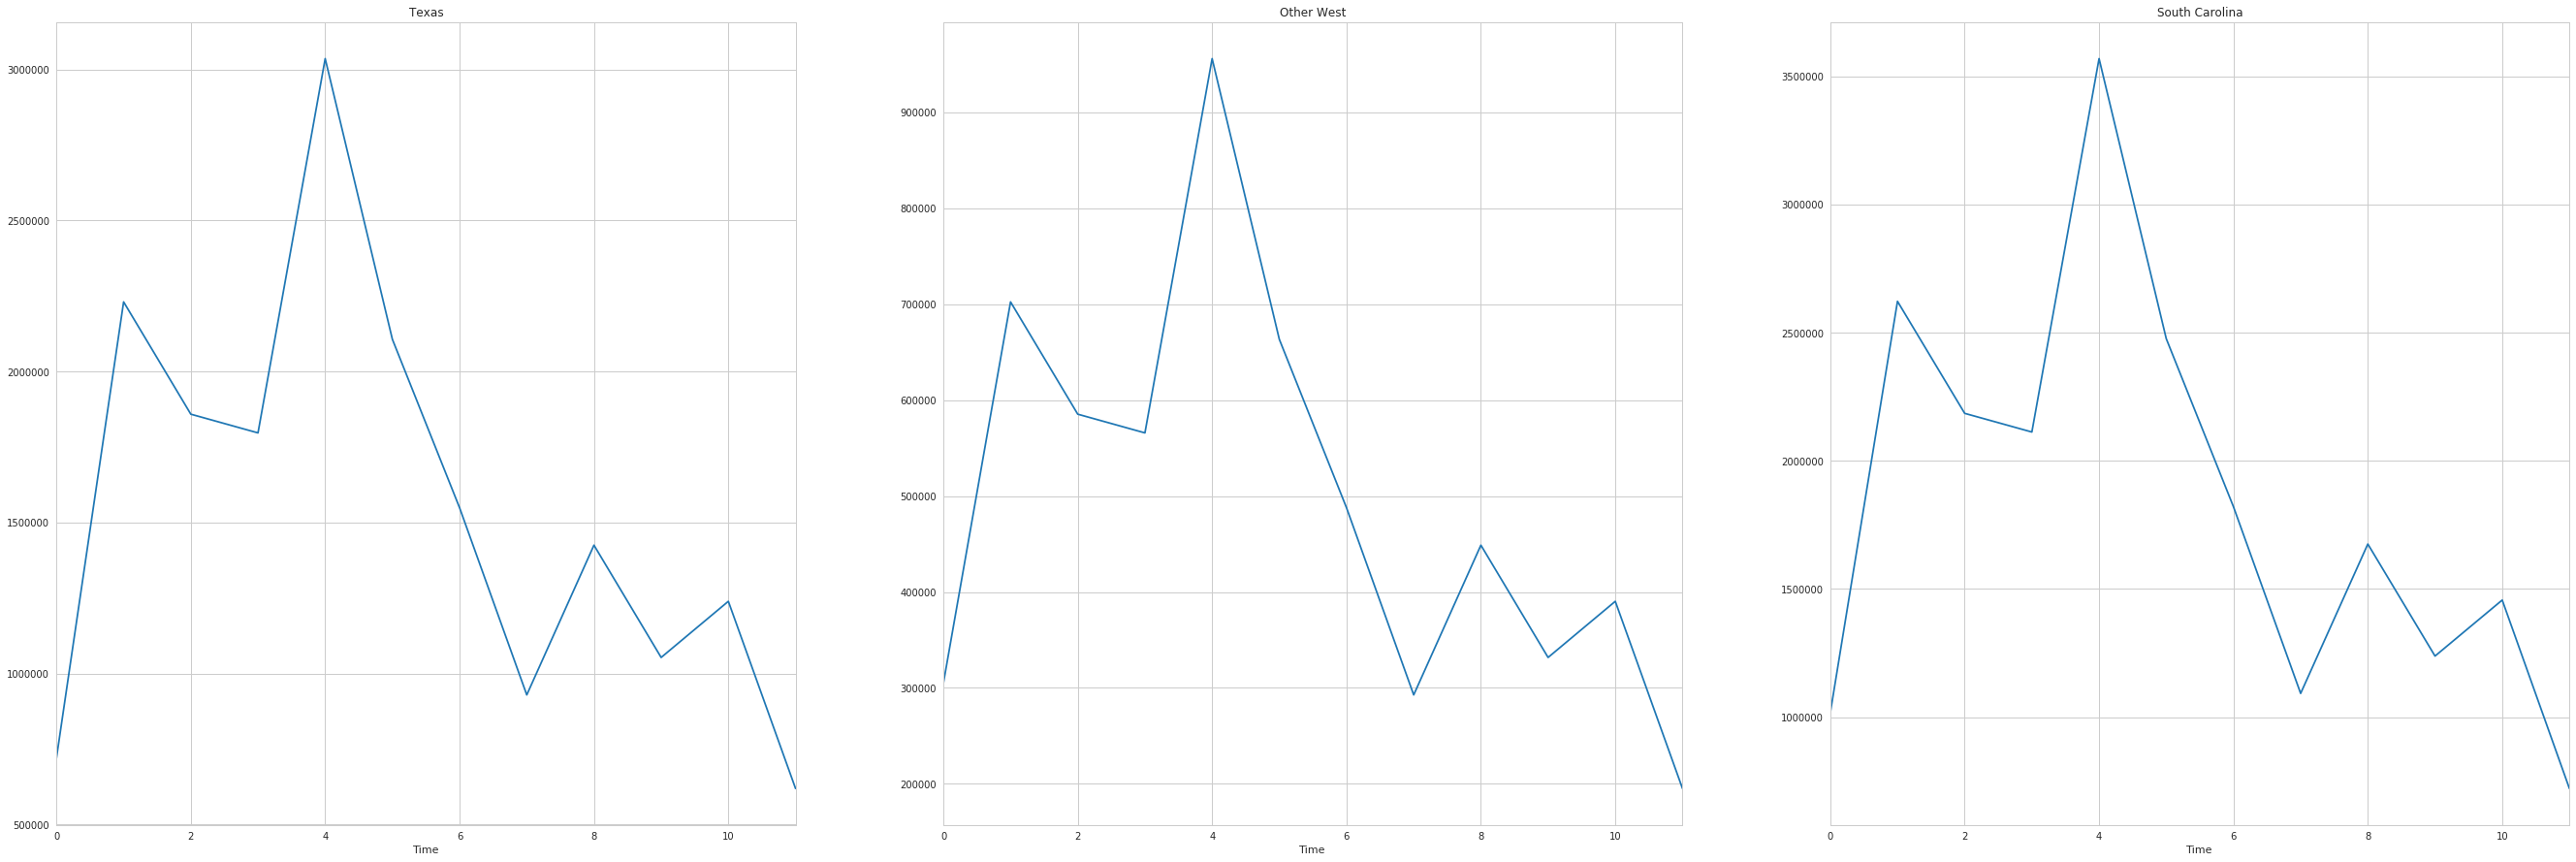

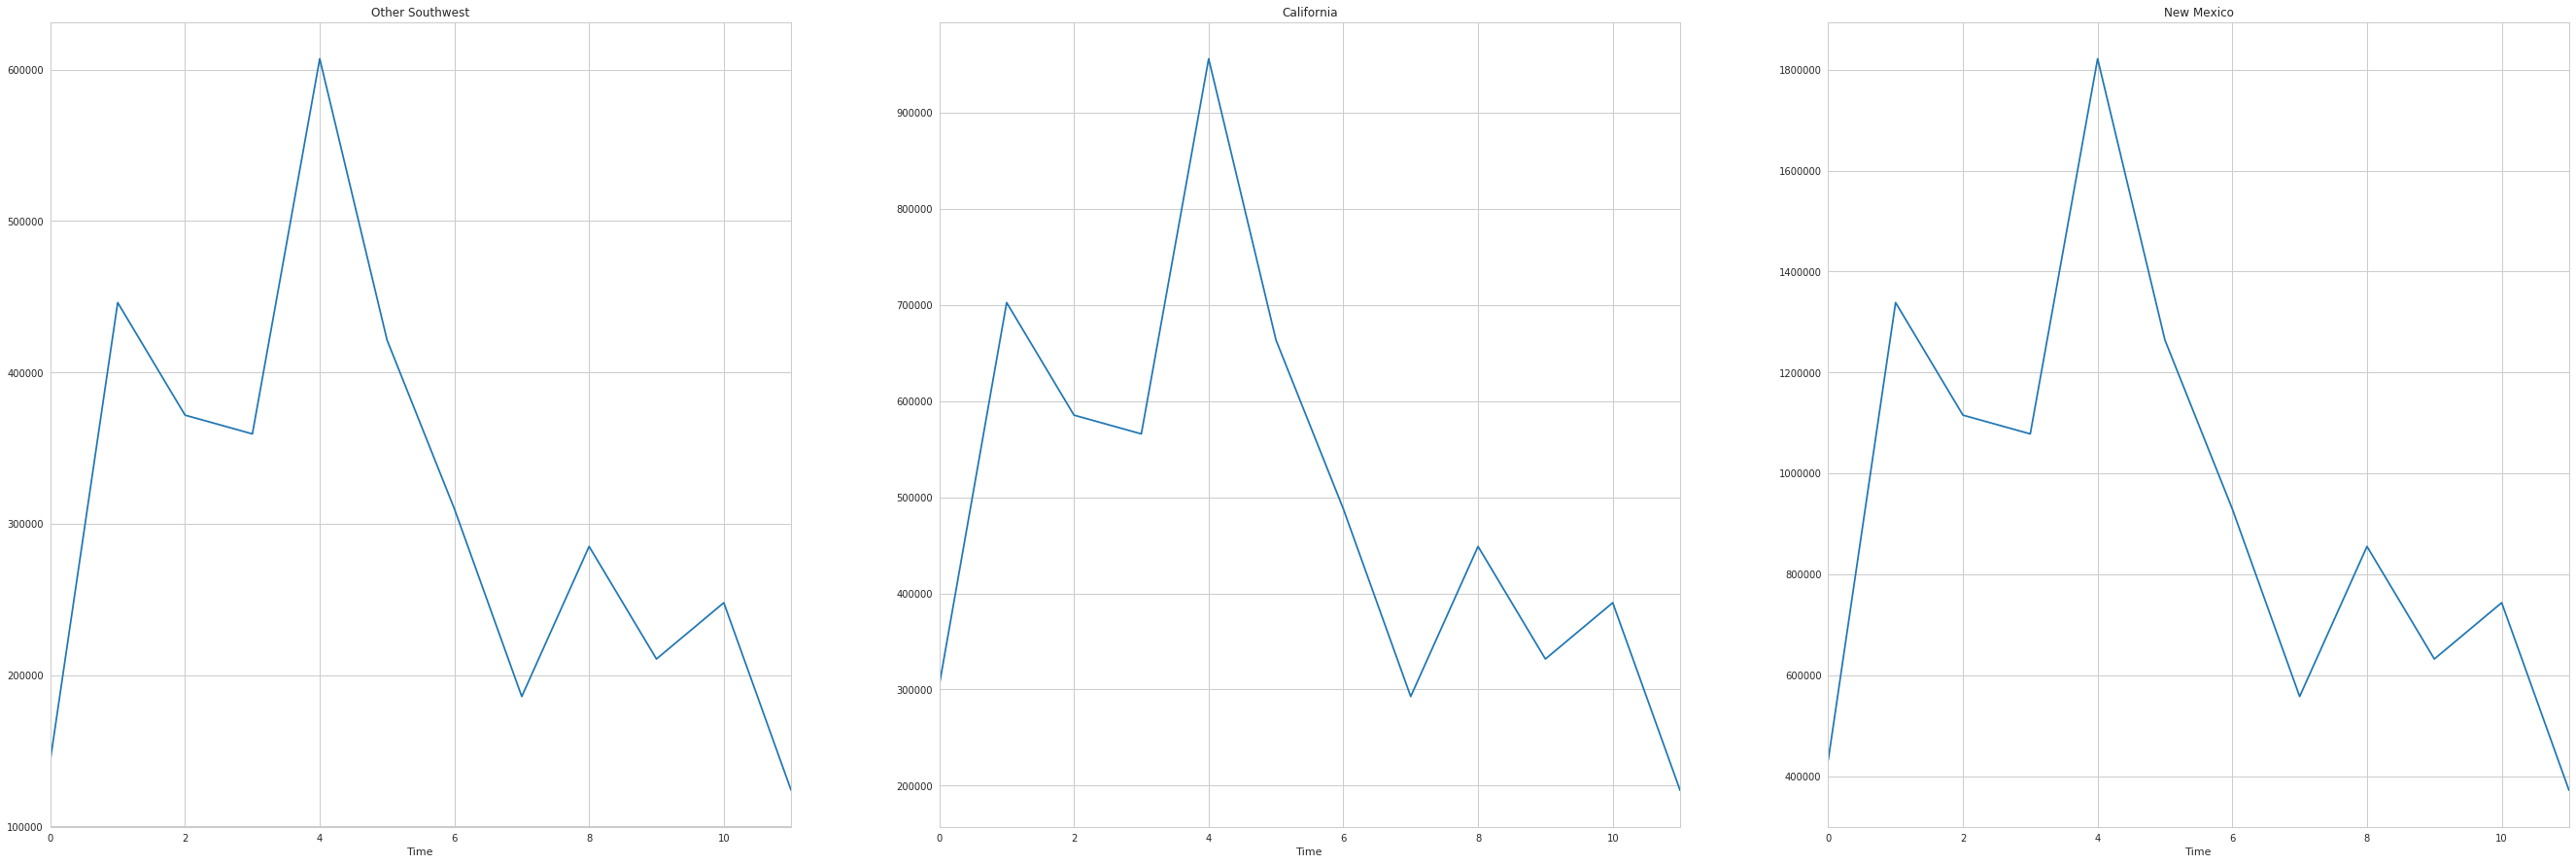

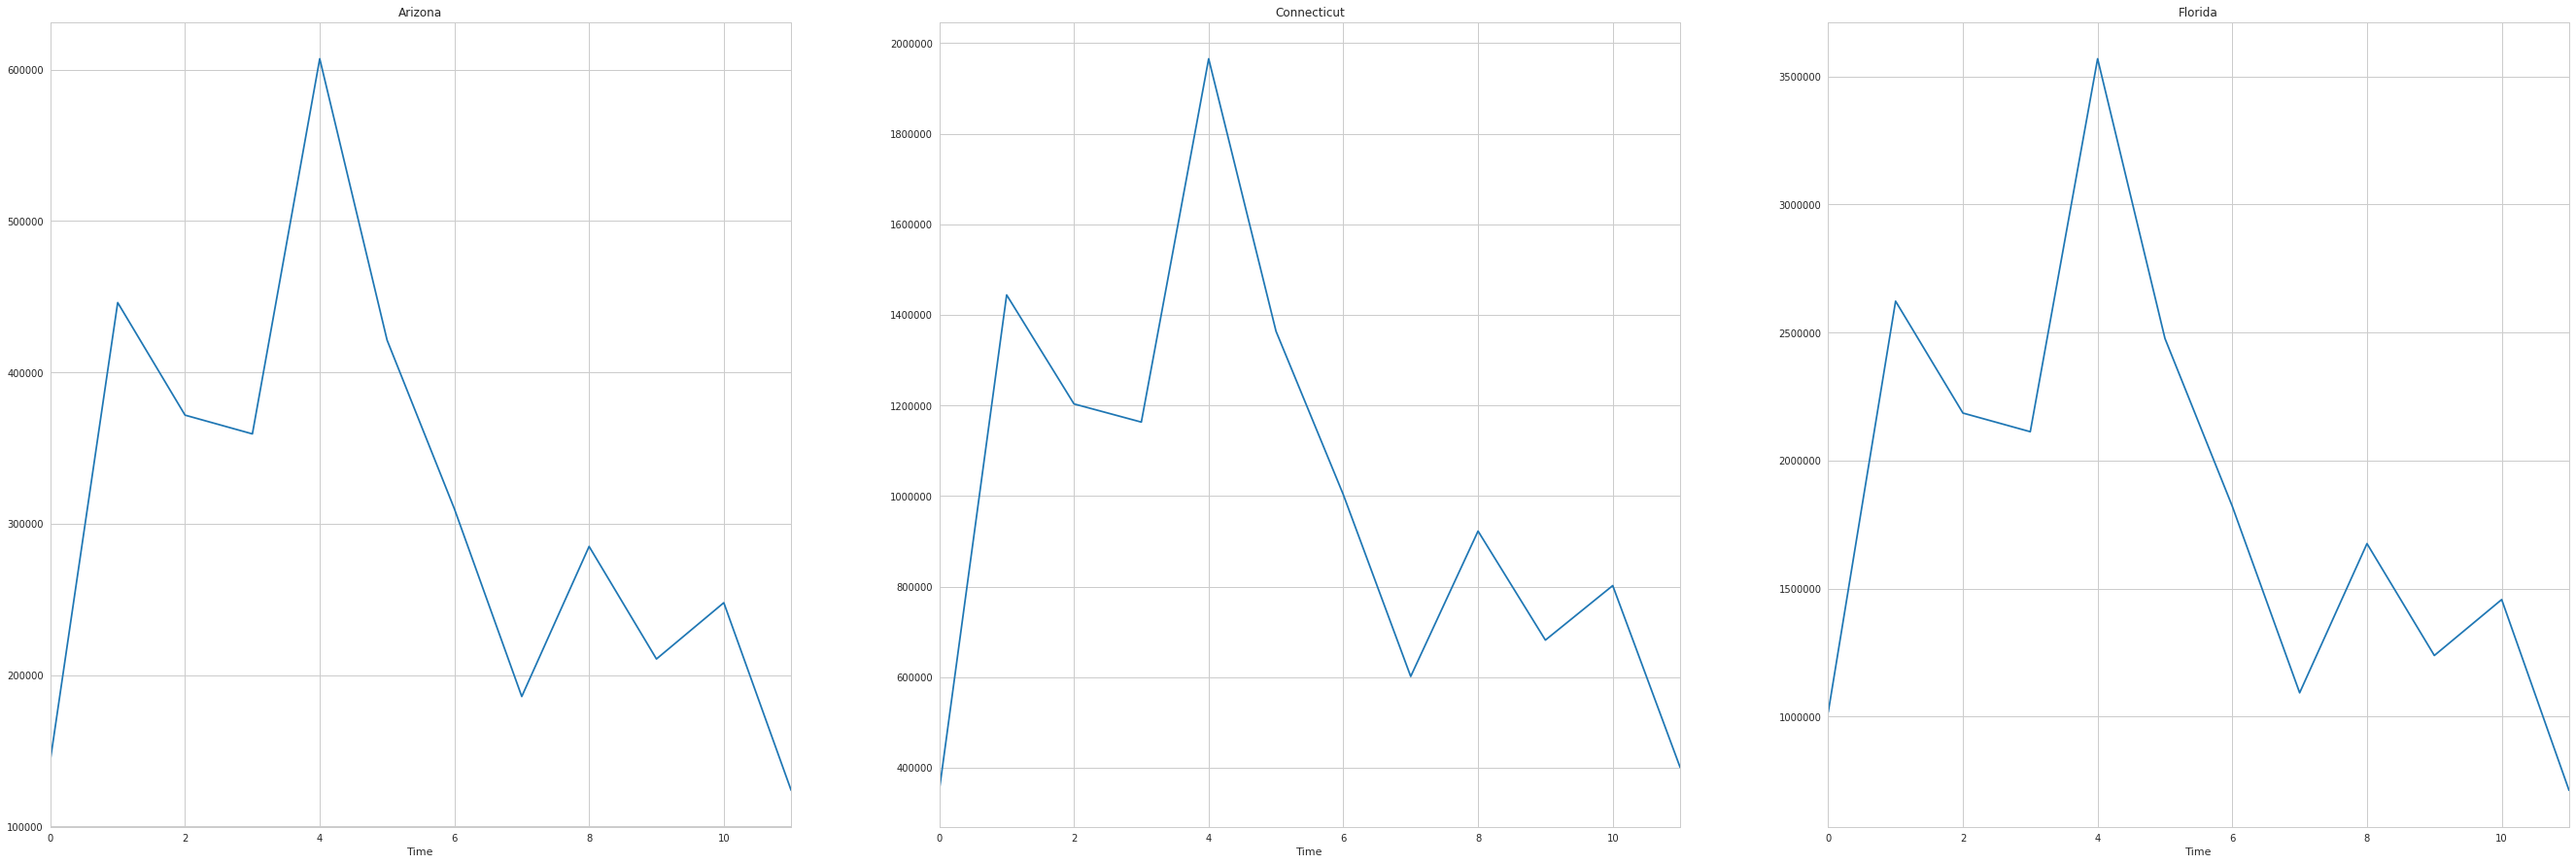

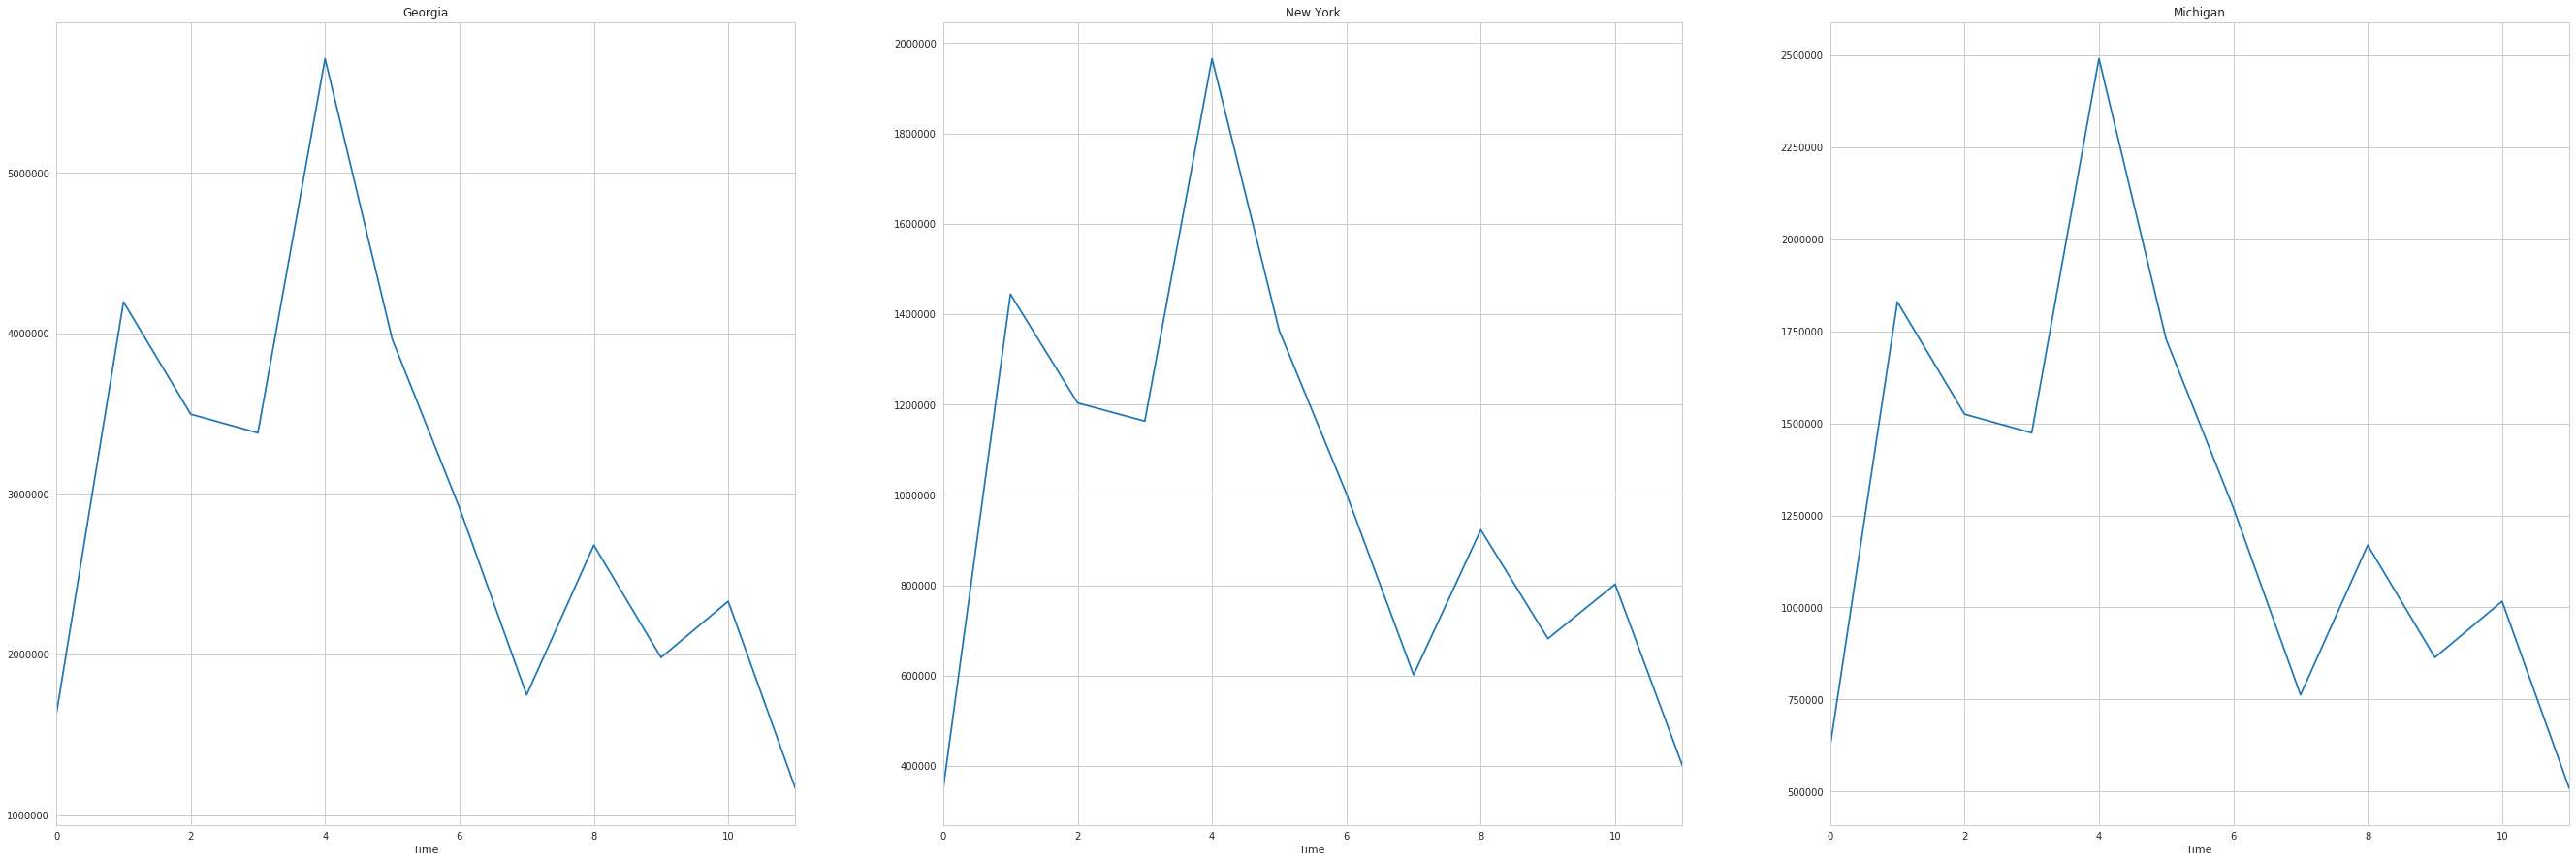

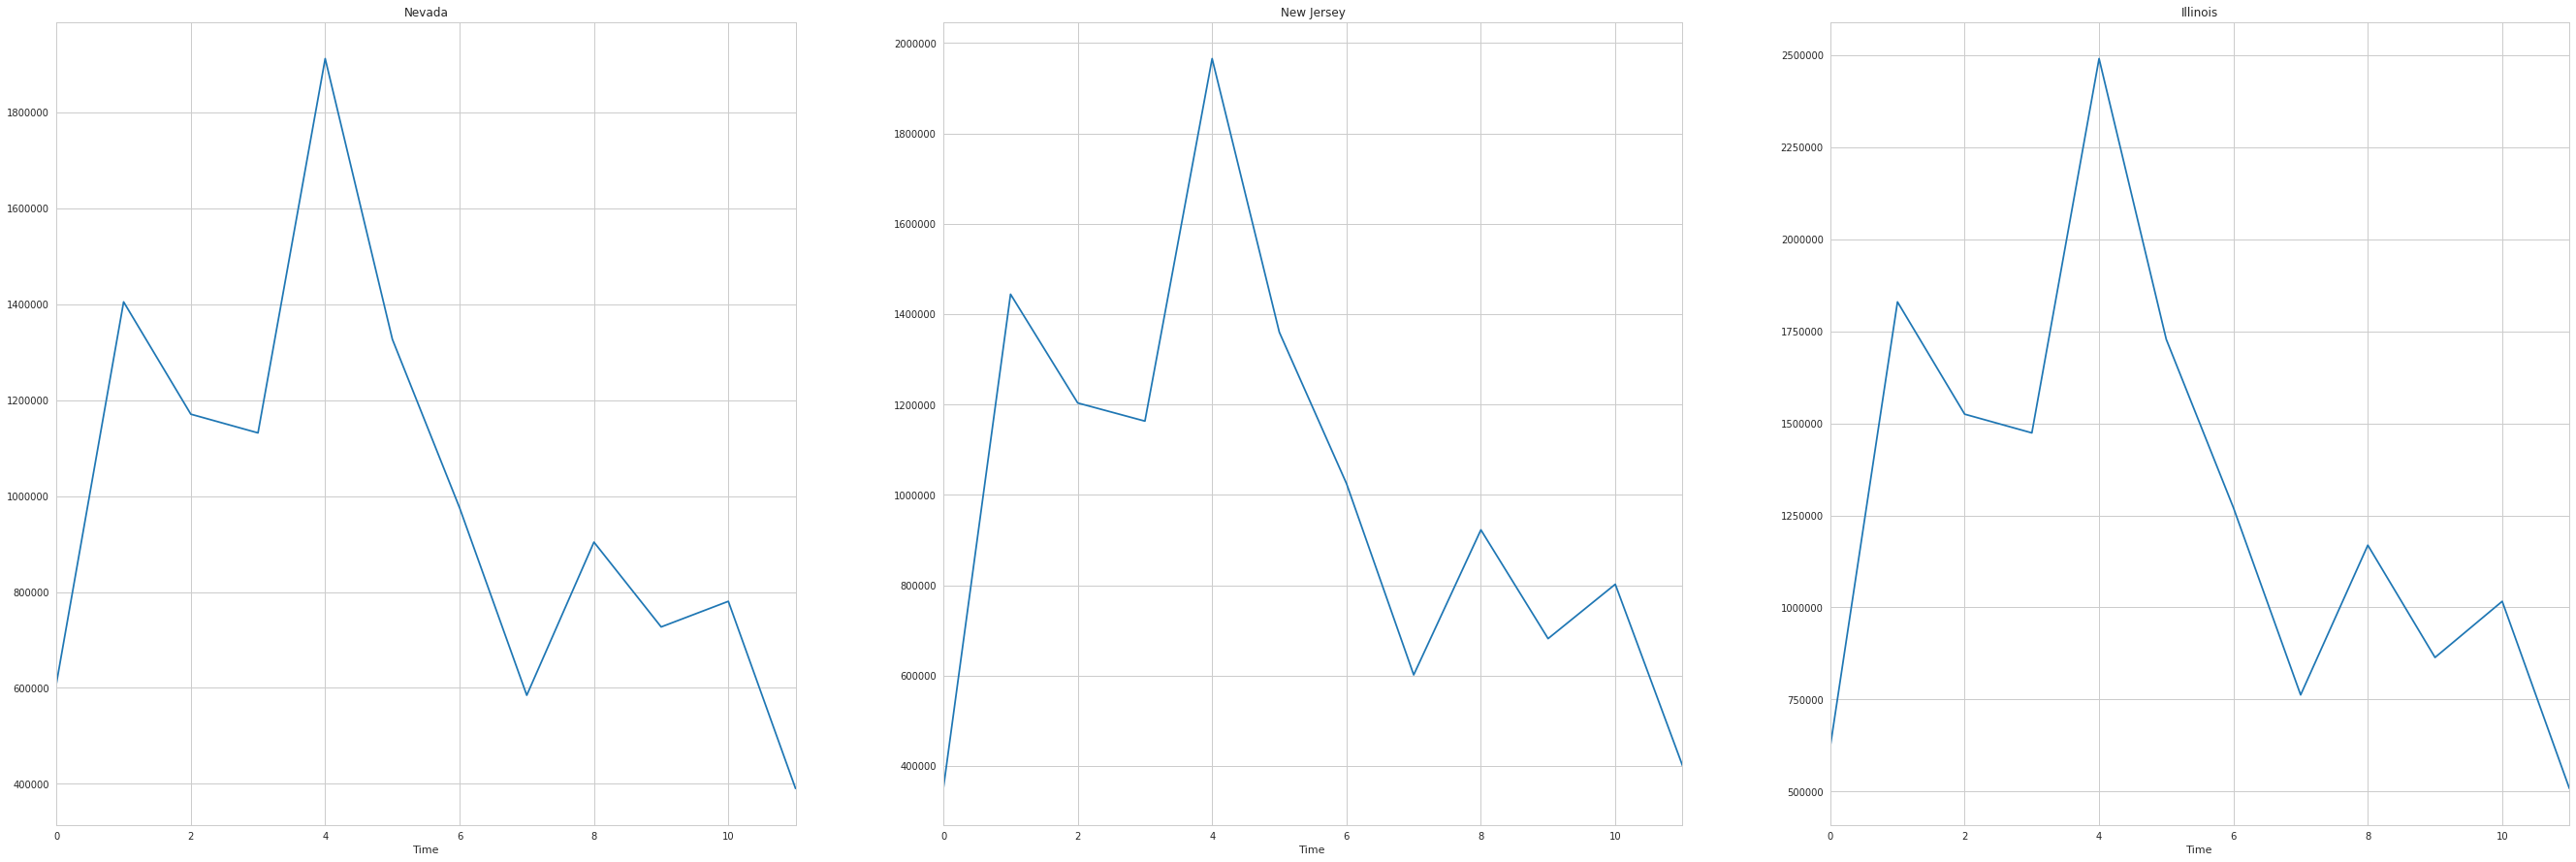

In [113]:
nonstationary_products = list(products_nonstationary.keys())

for i in range(12):
    begin = 3*i
    end = 3*(i+1)
    draw_time_series(final_trans, nonstationary_products[begin:end])

we can see from the plots above that different regions have quite different patterns

### Plot log data
From the plot below, log still cannot steable variance, so just keep orgin price in modelling.

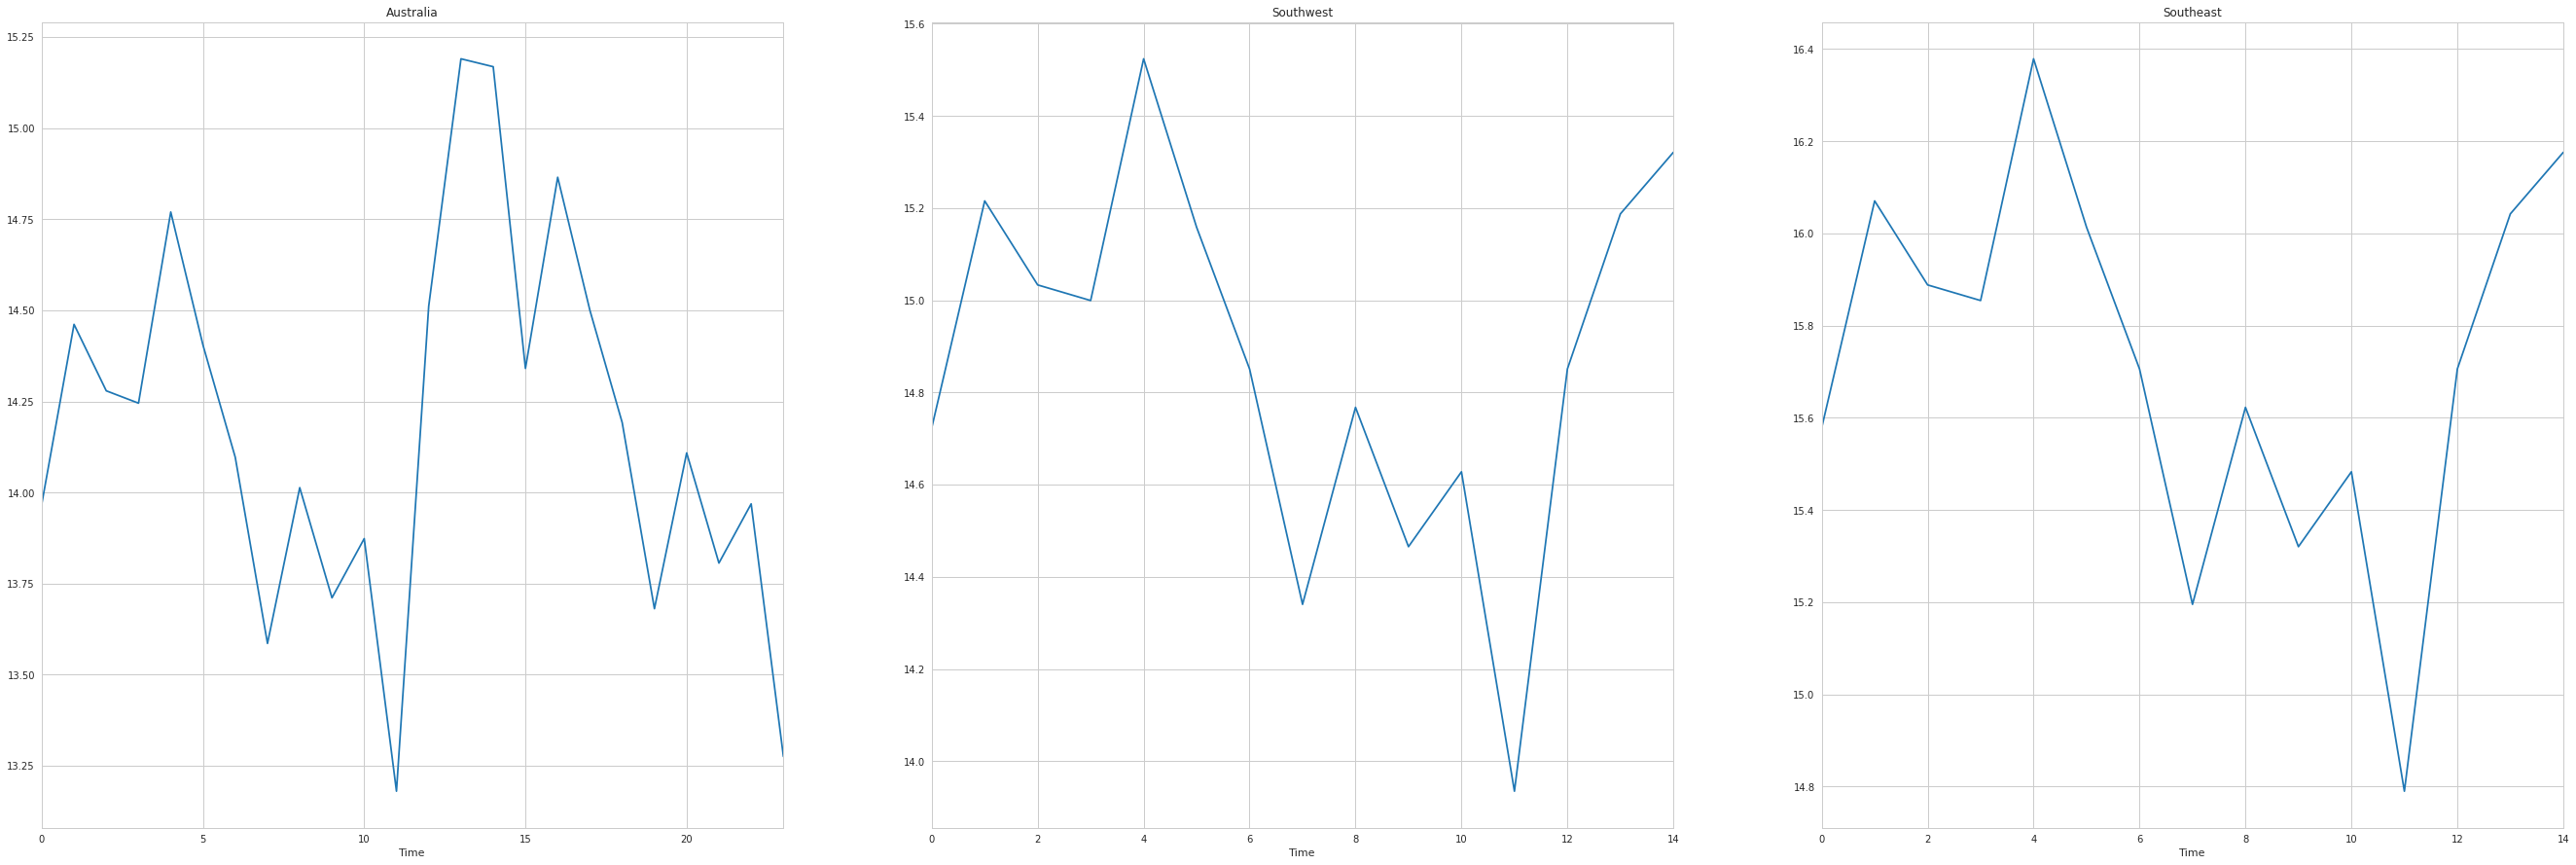

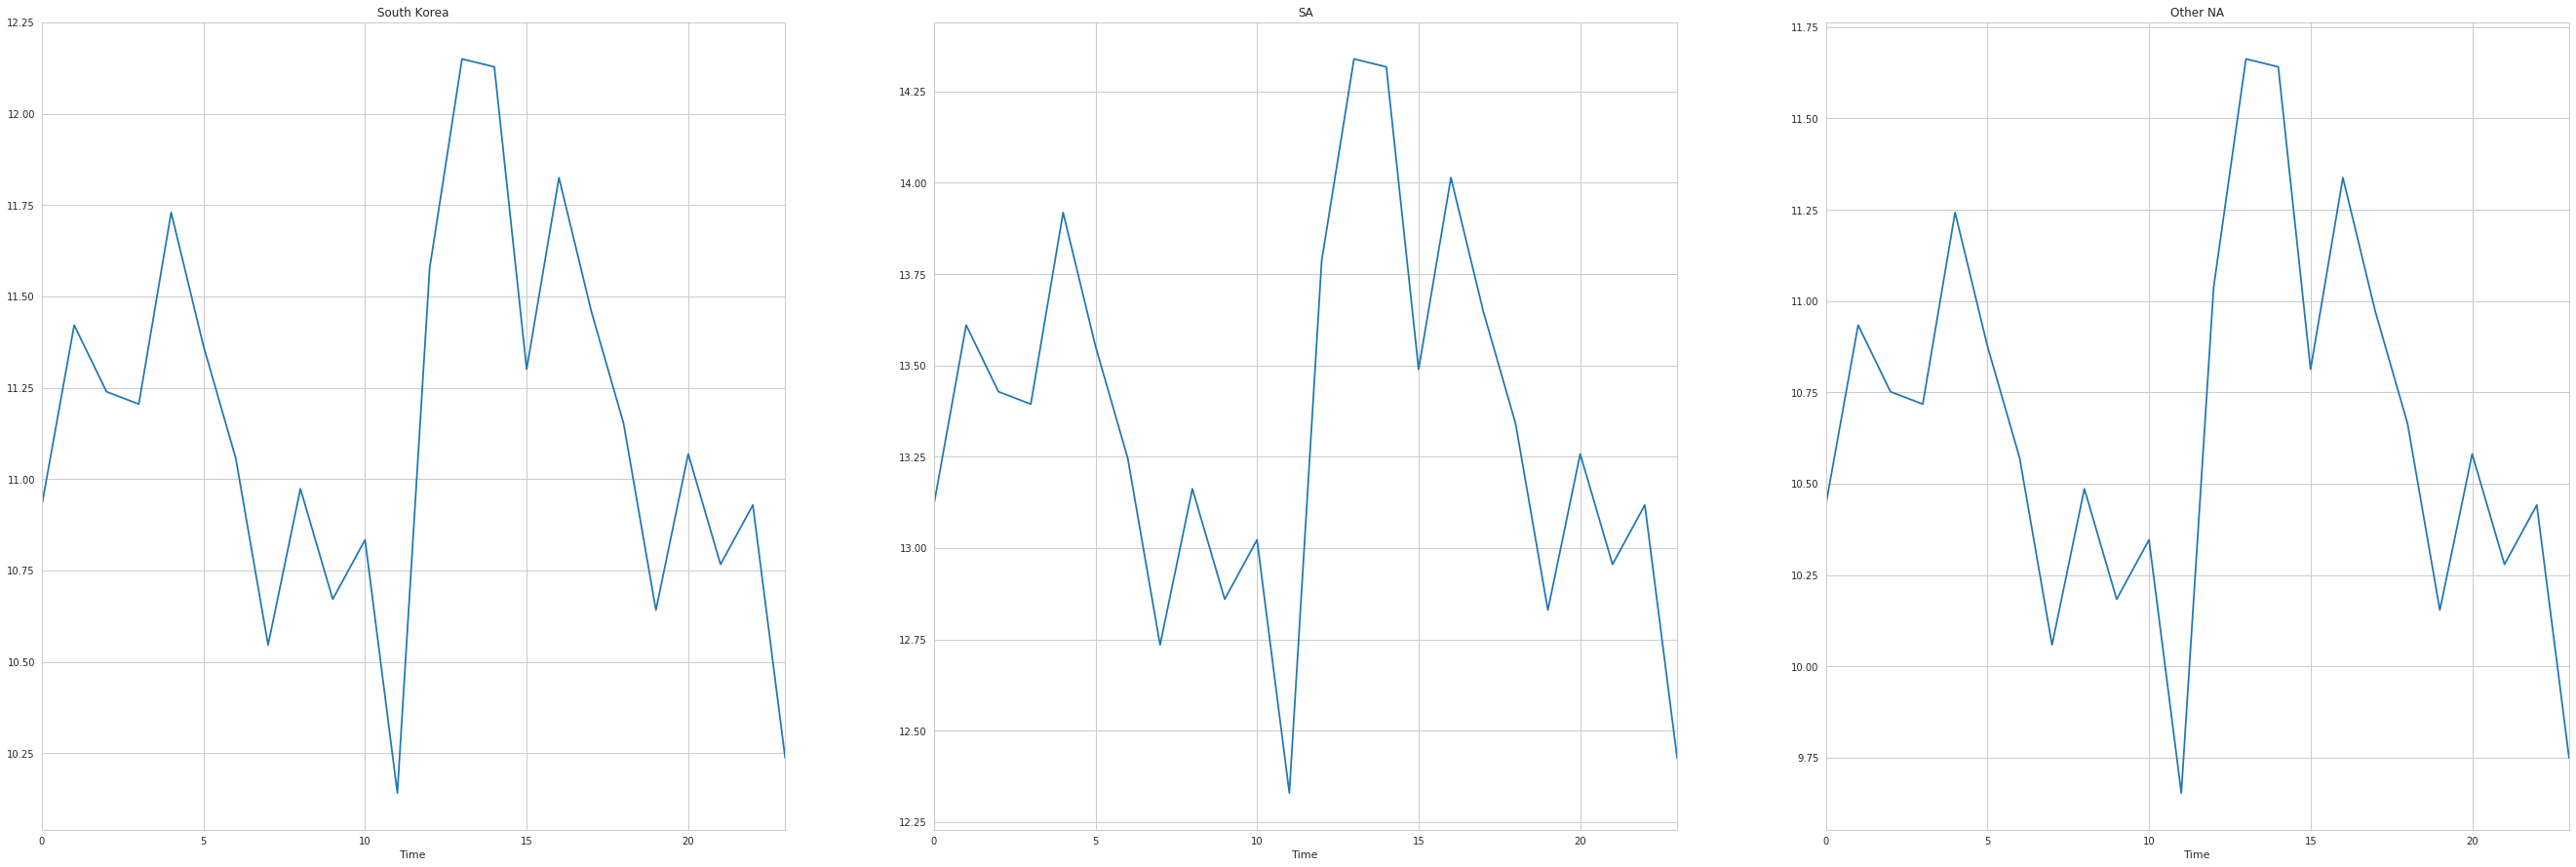

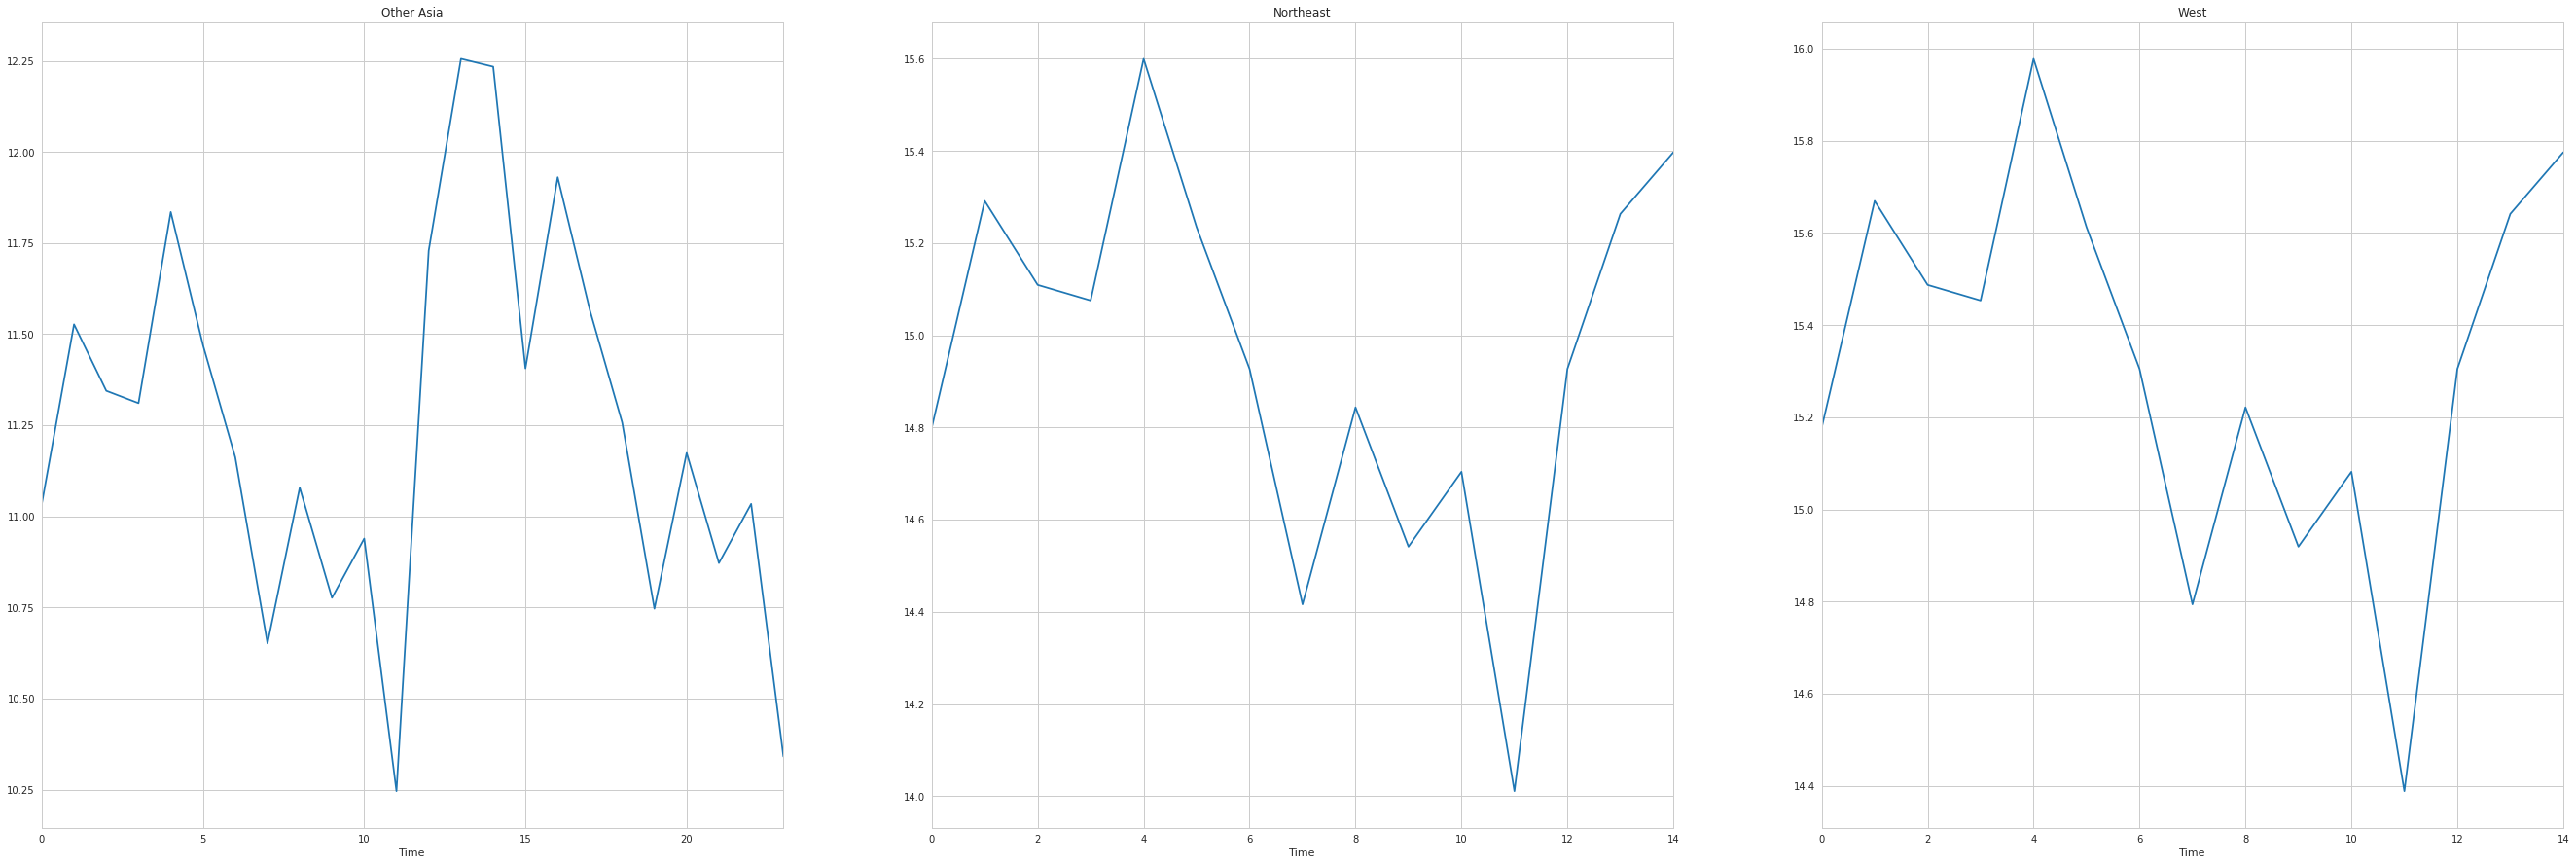

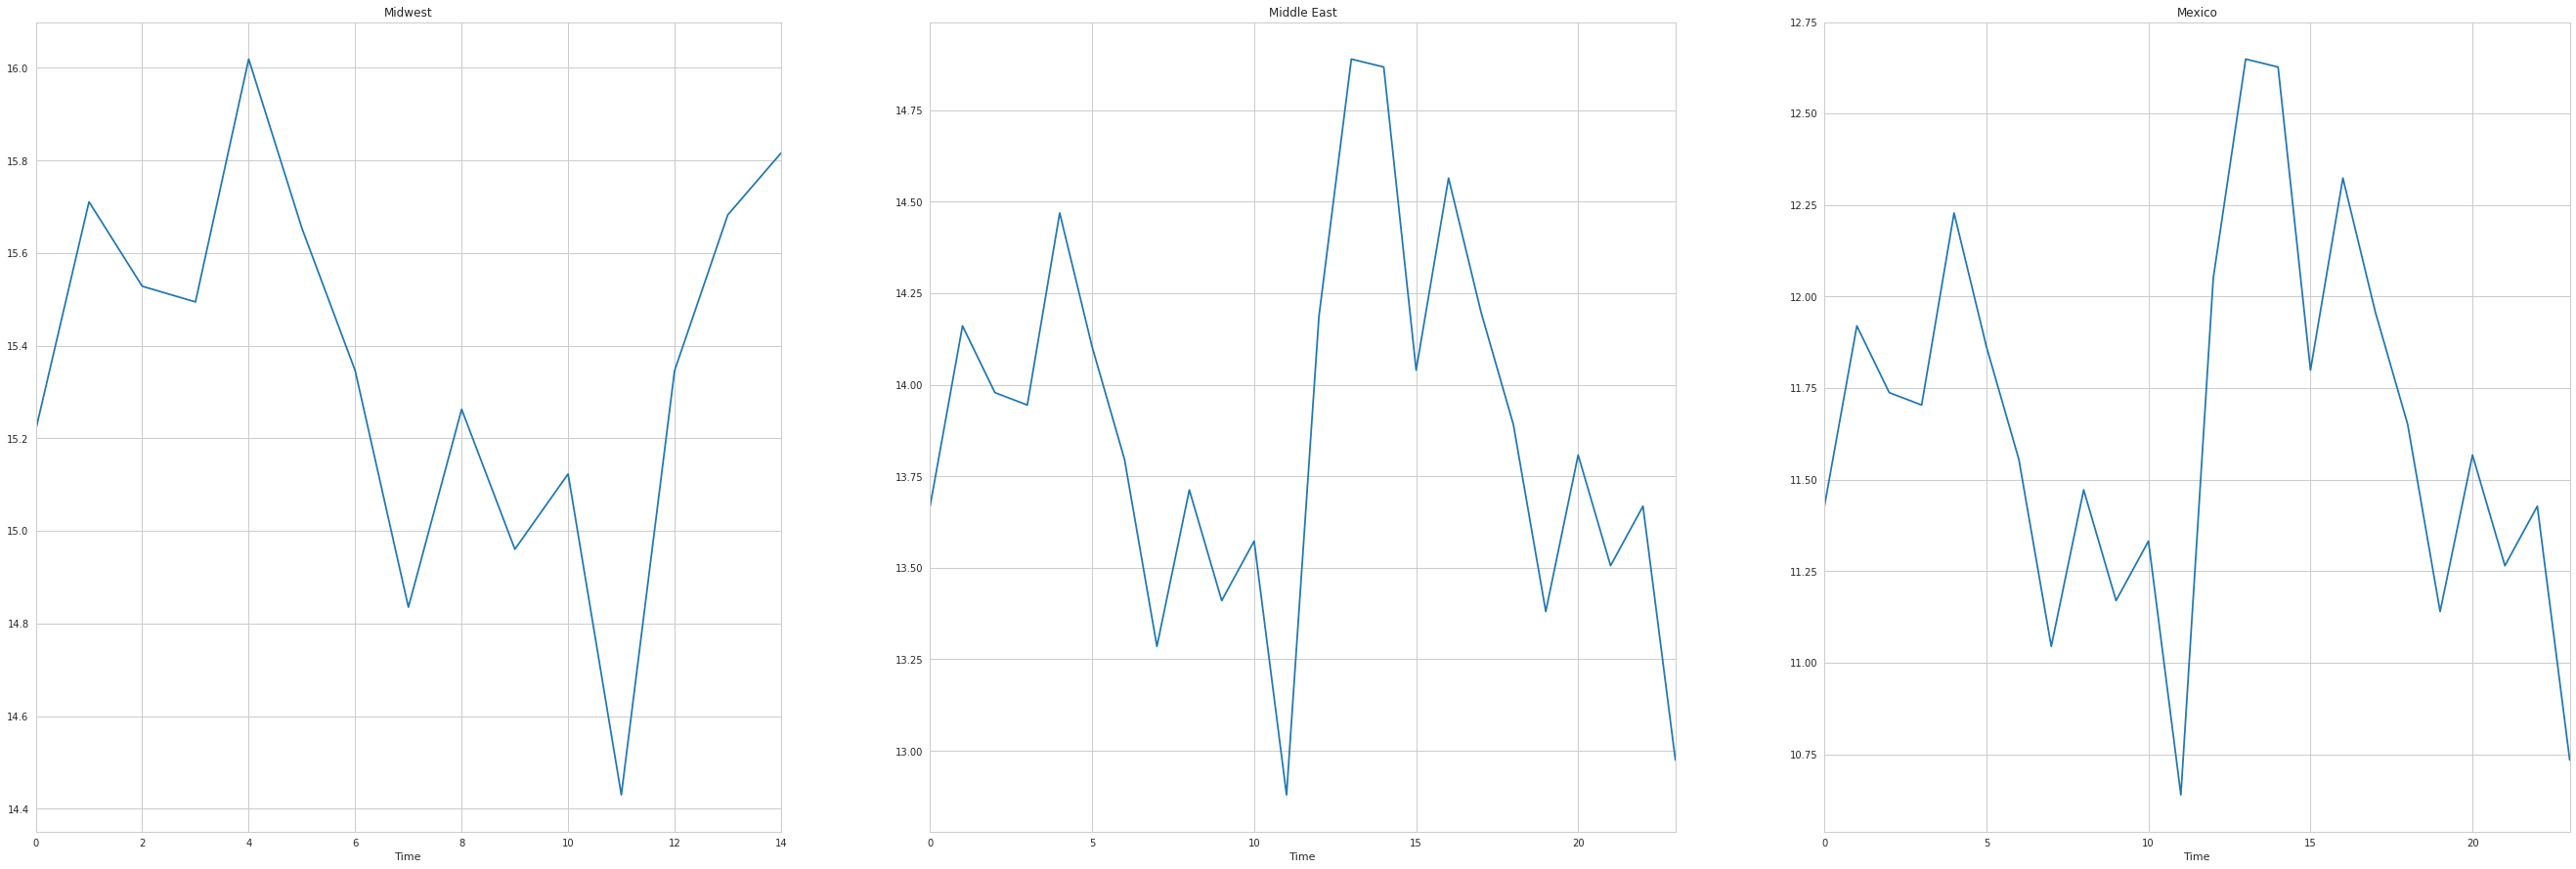

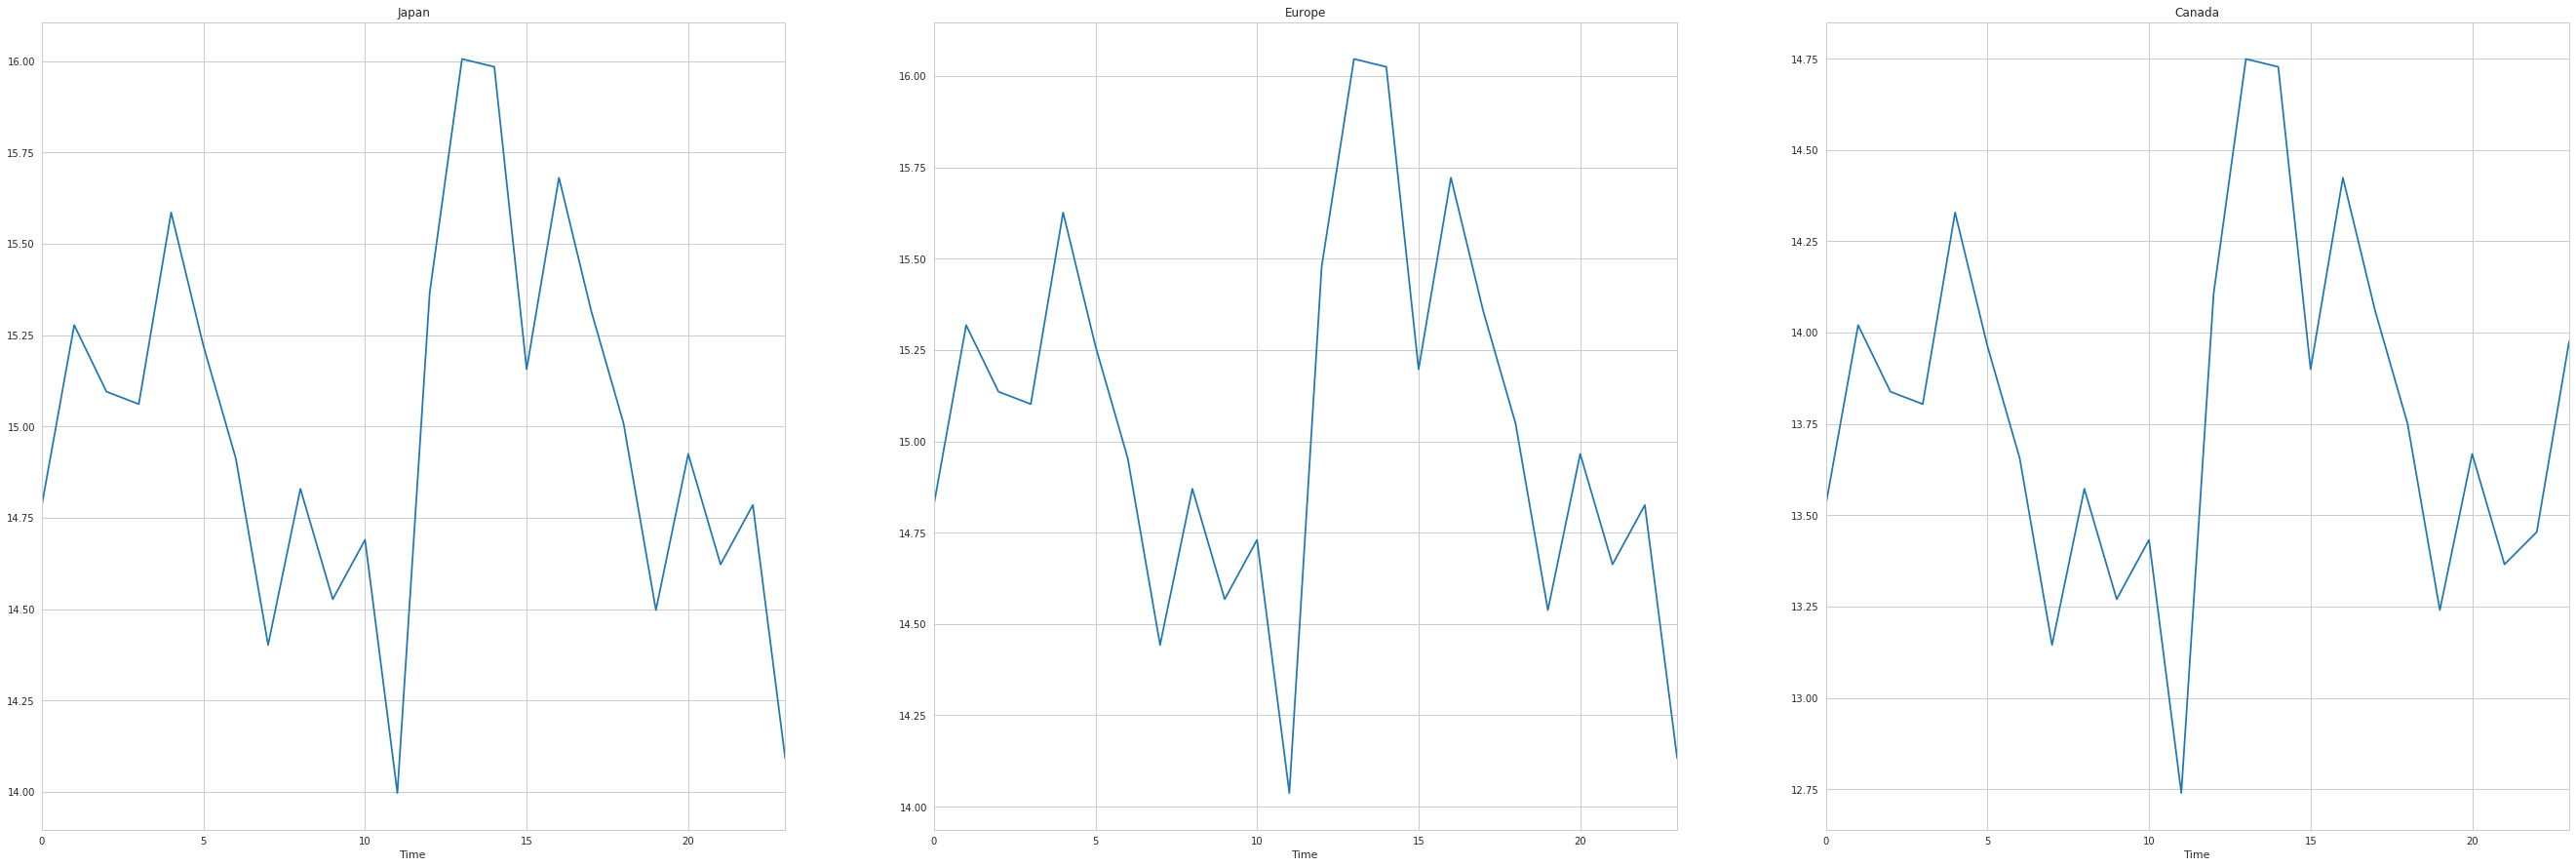

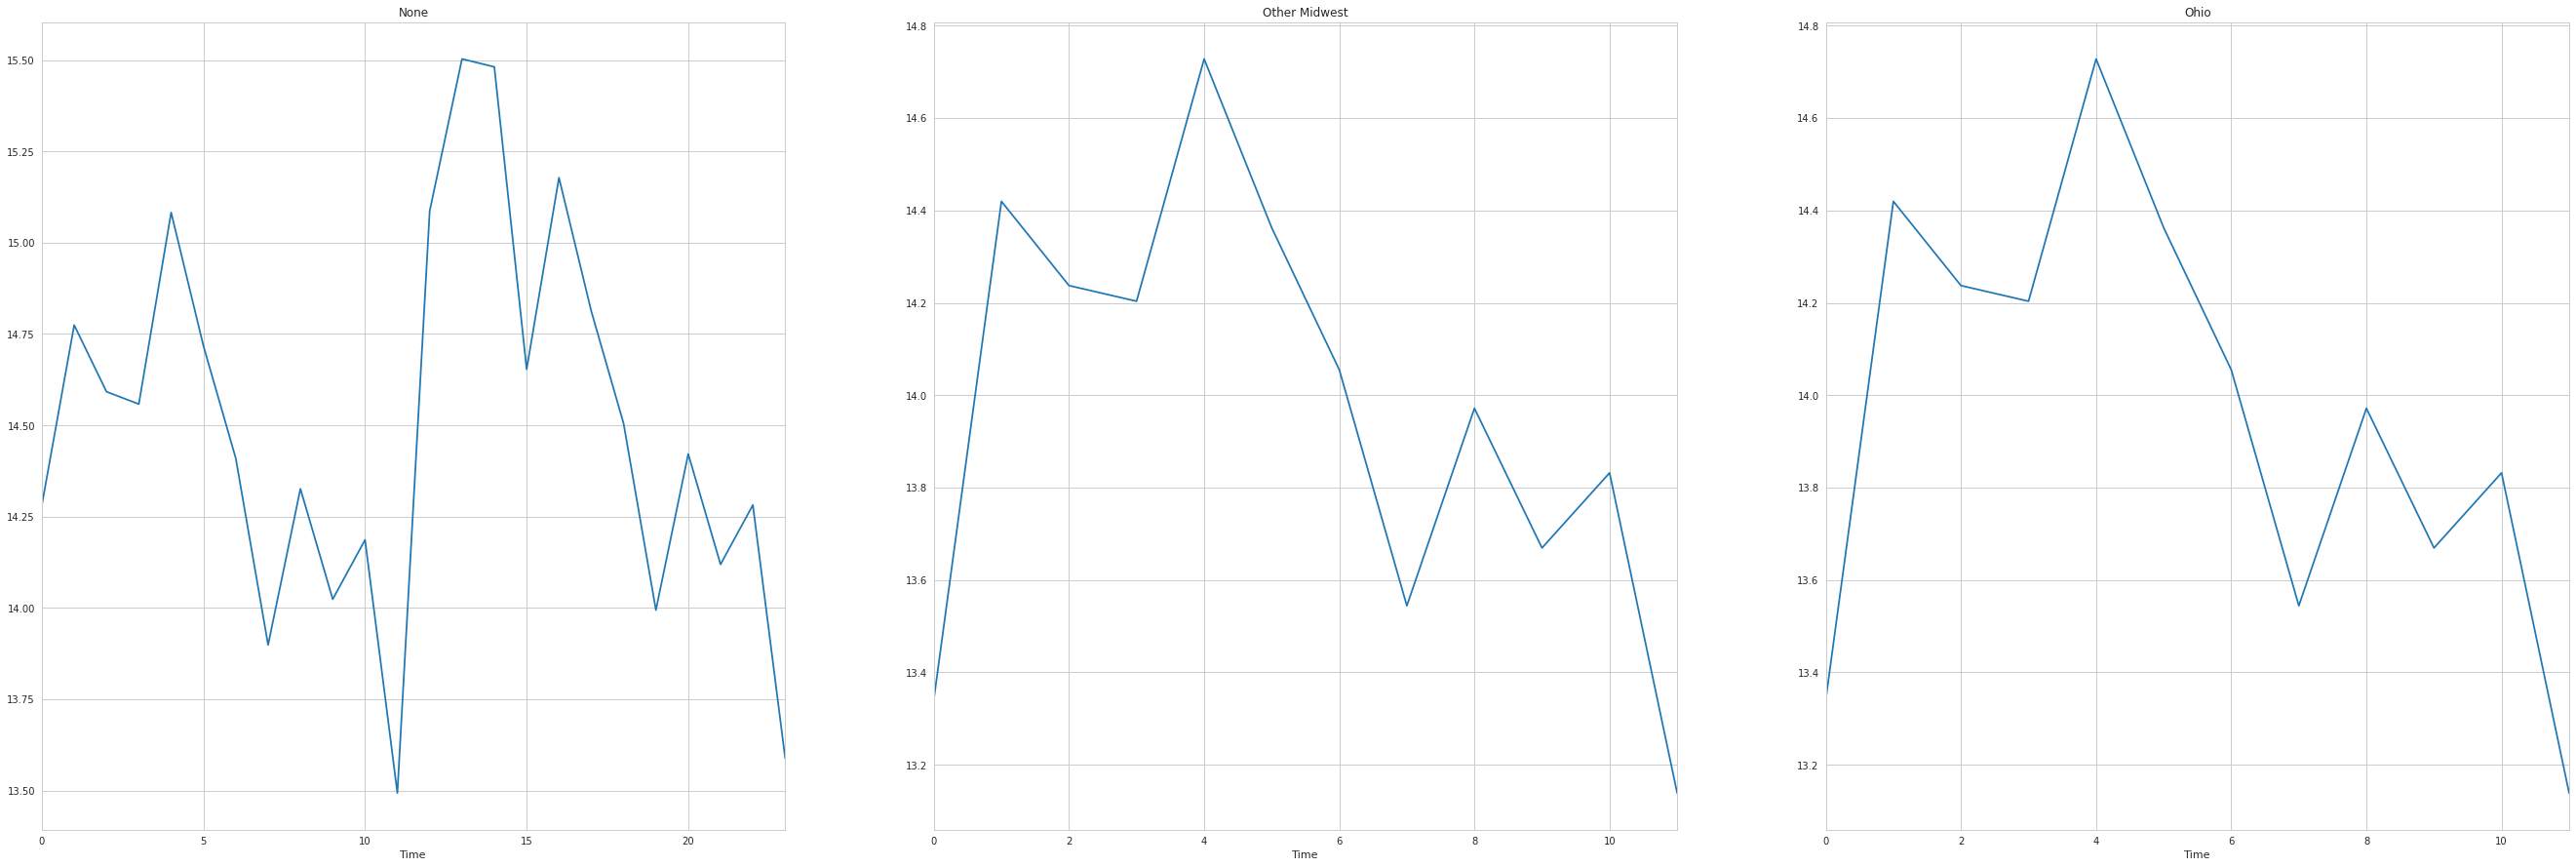

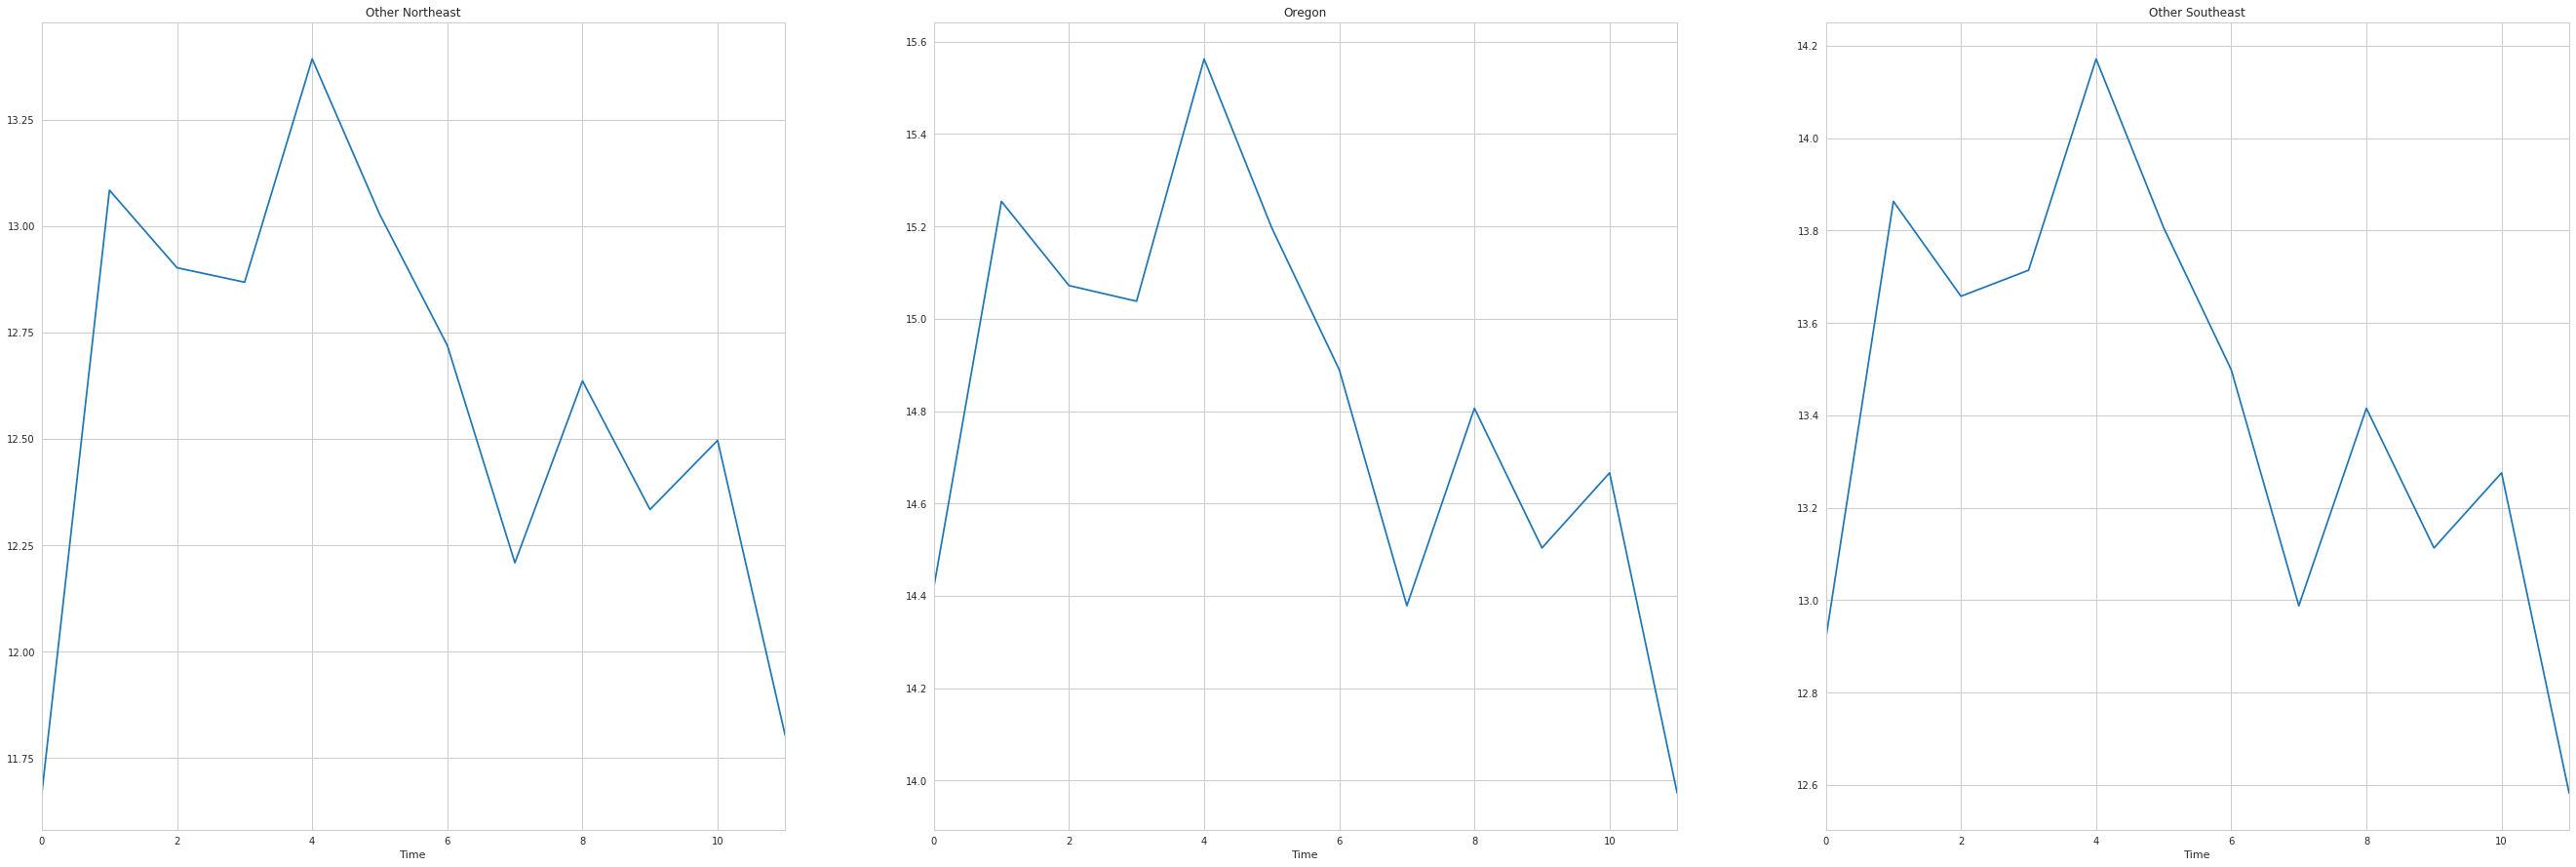

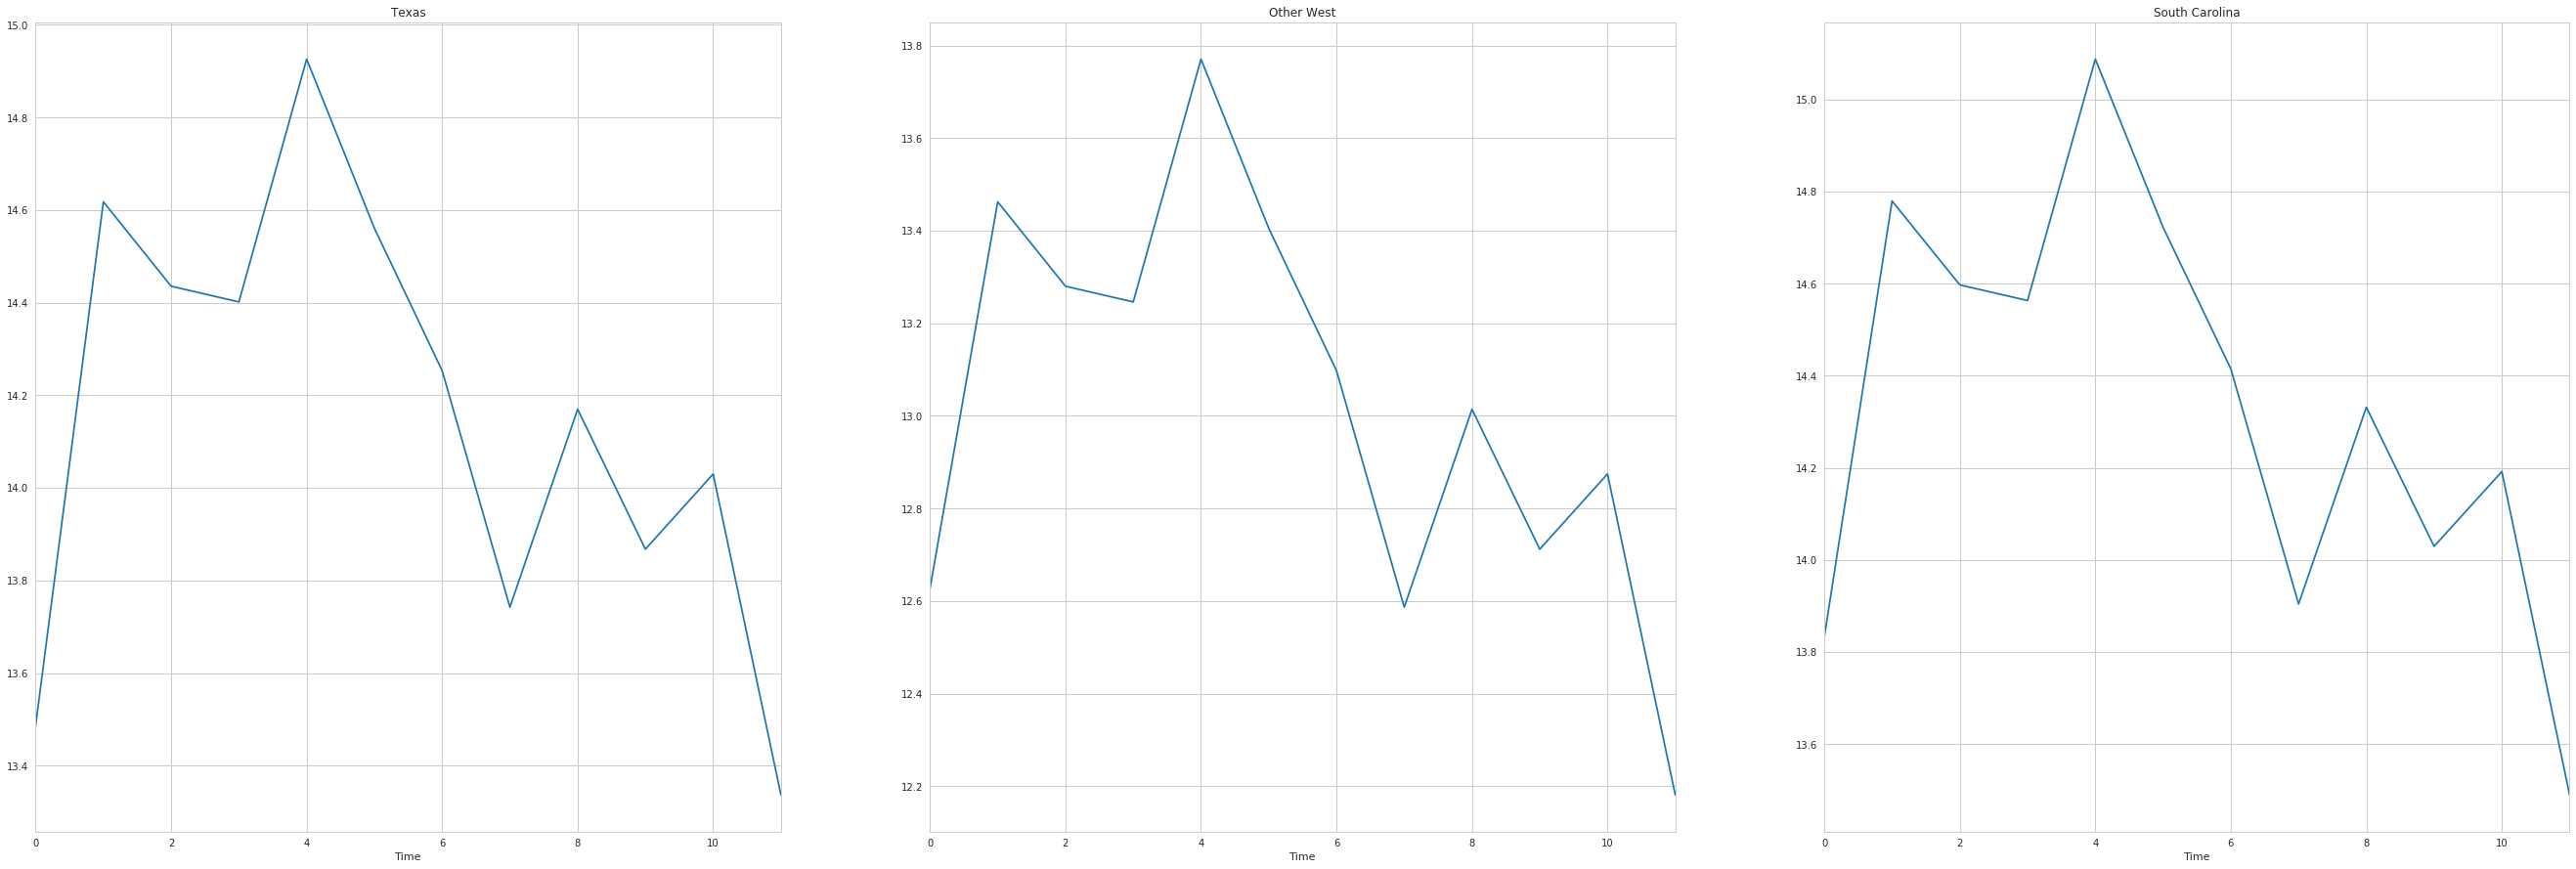

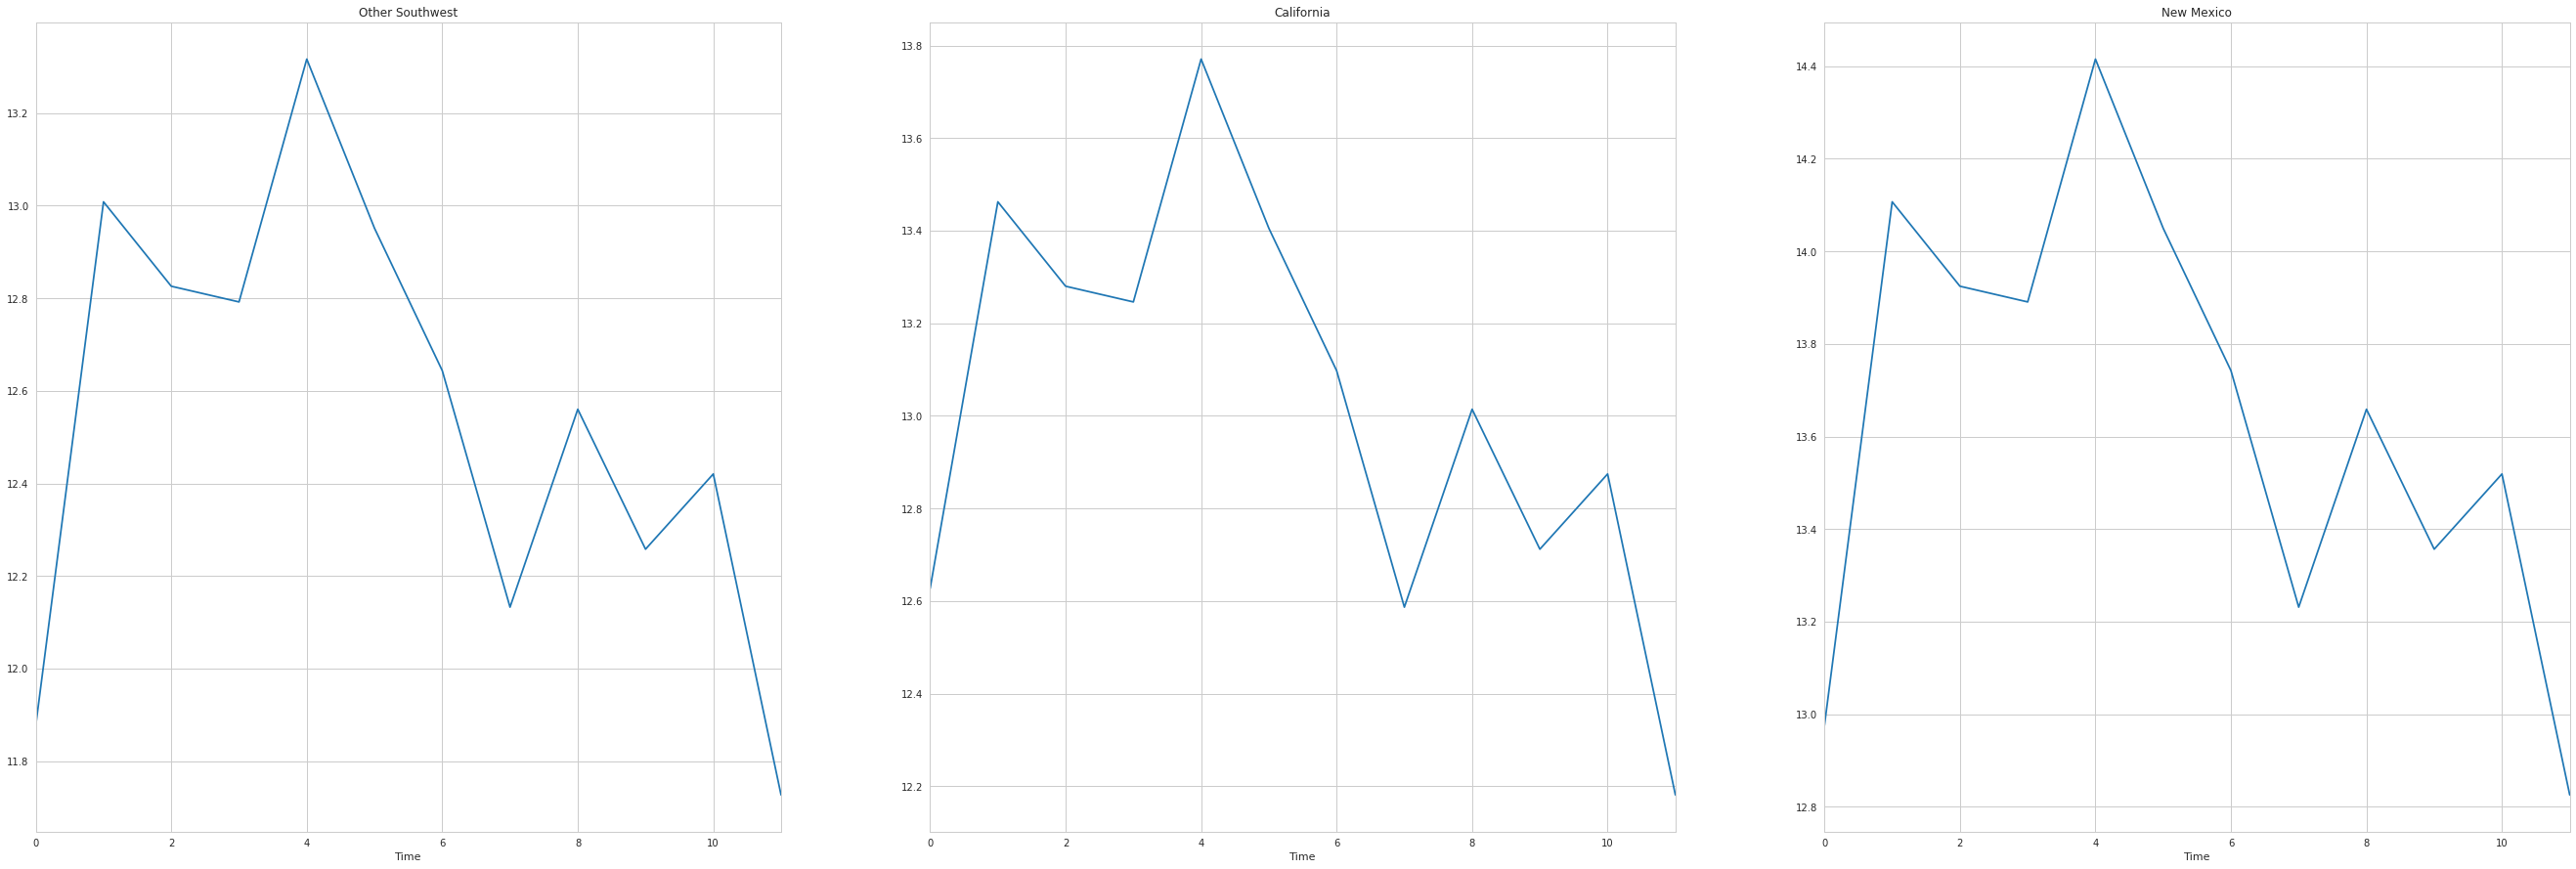

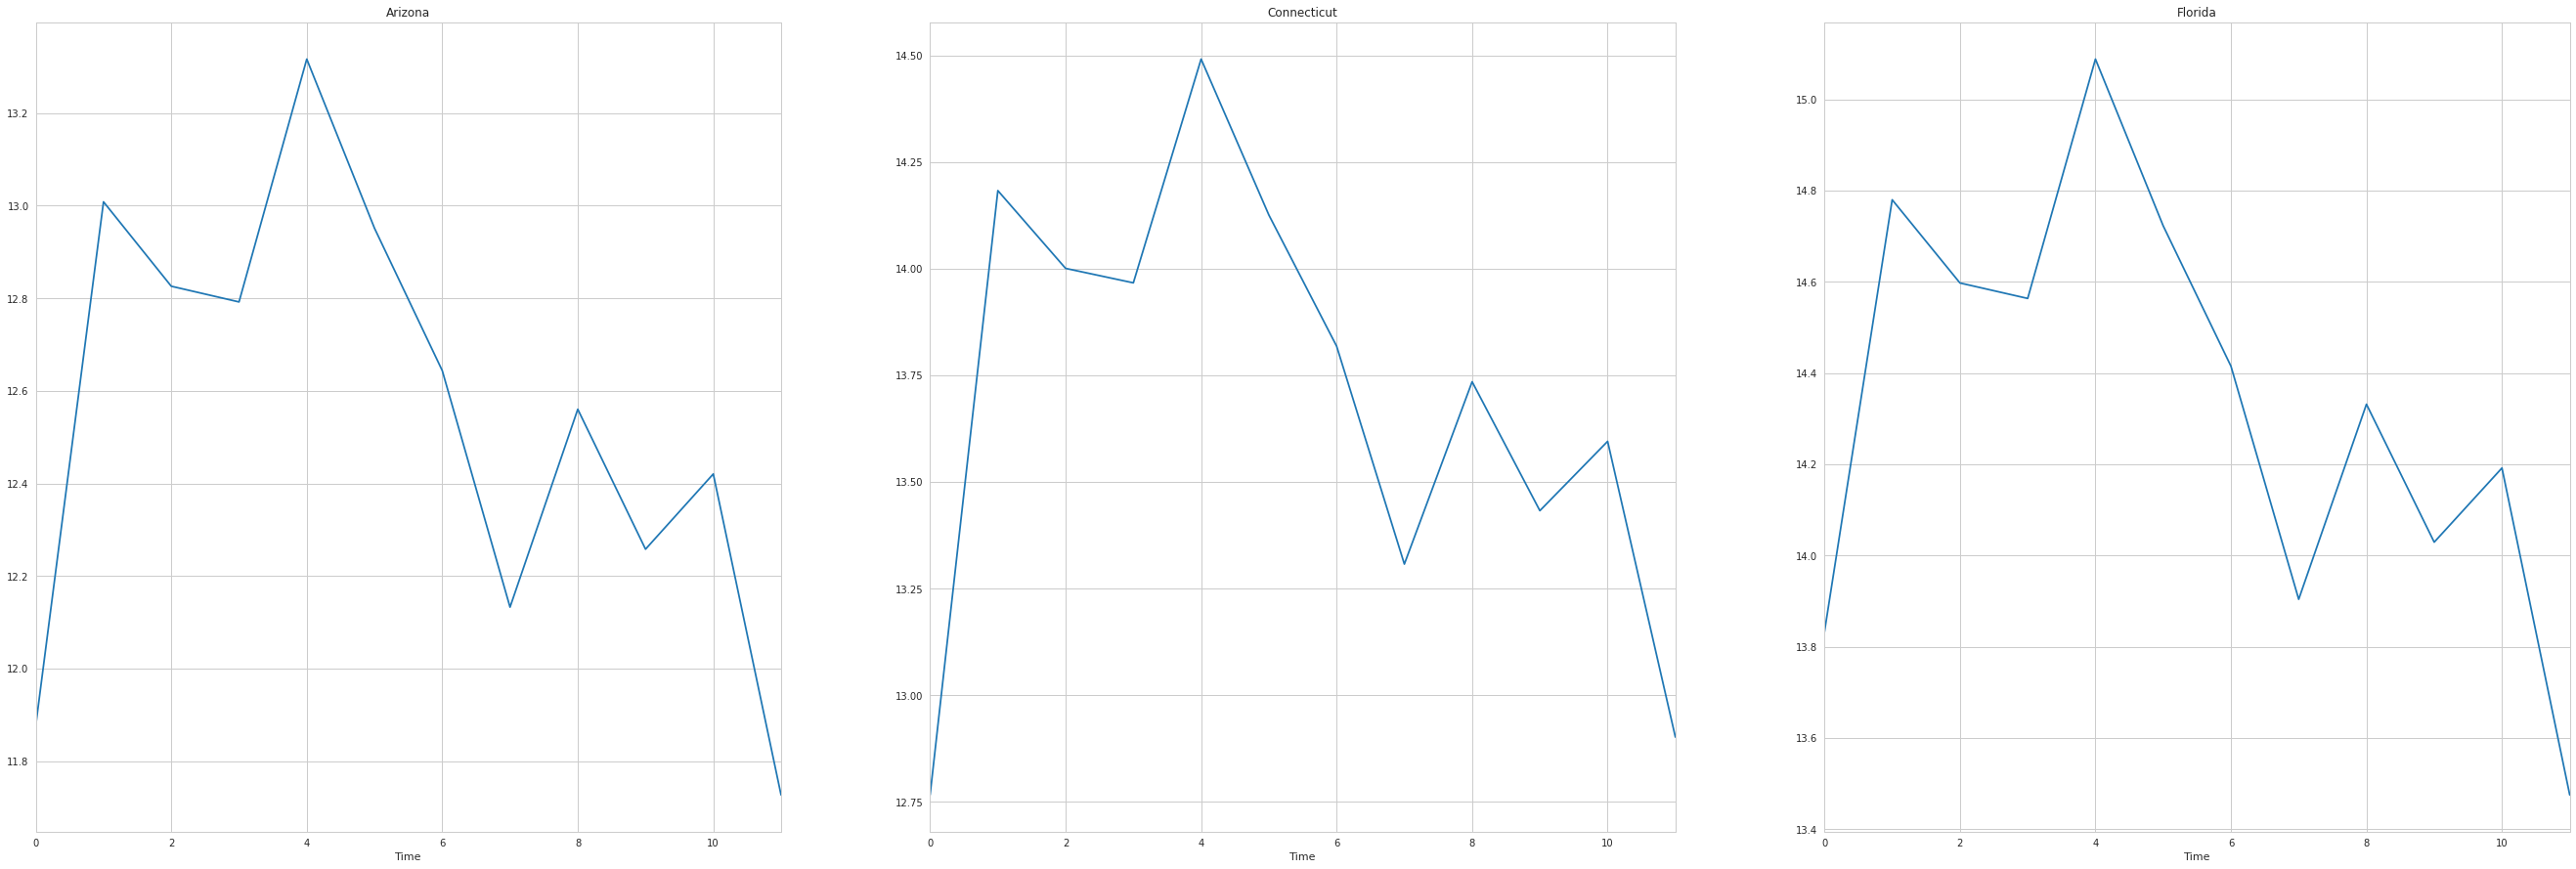

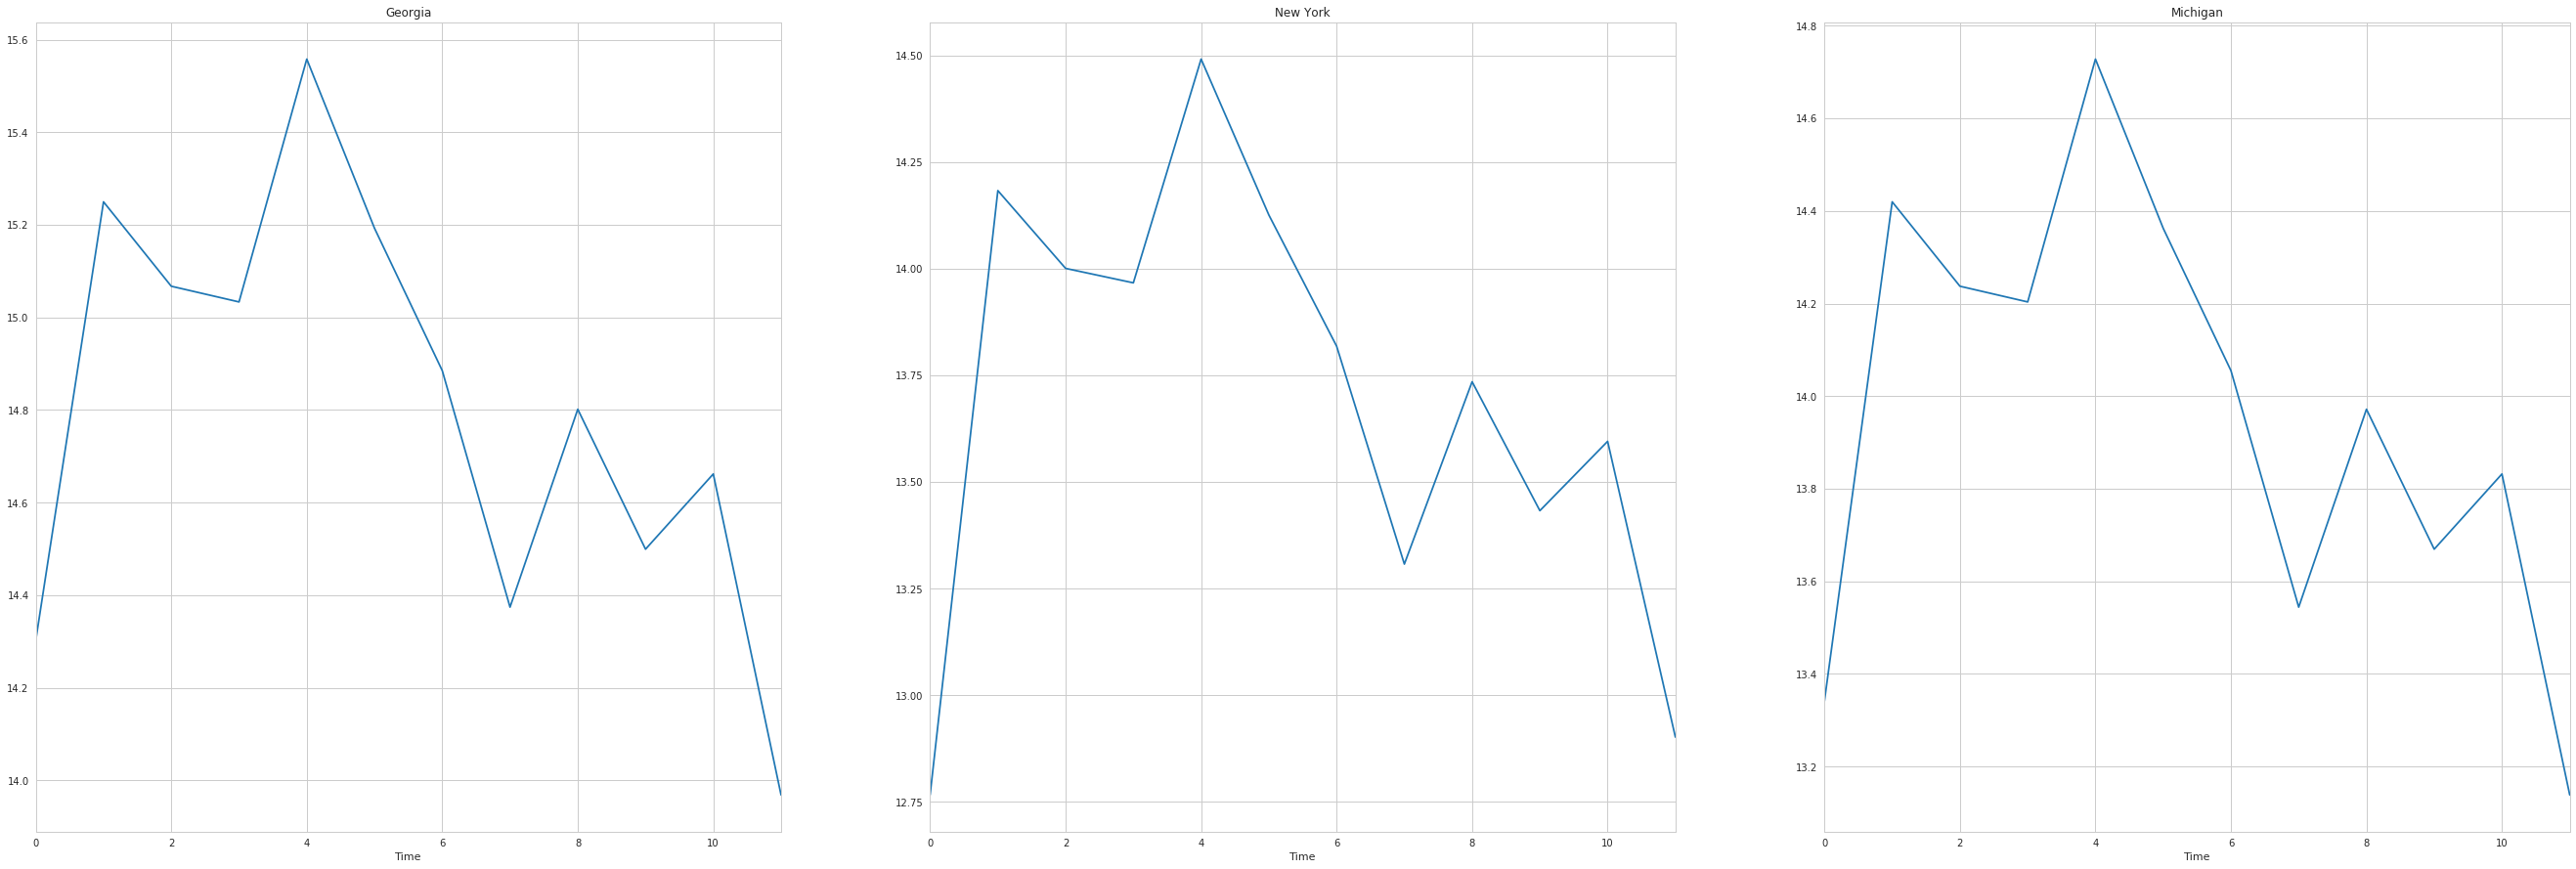

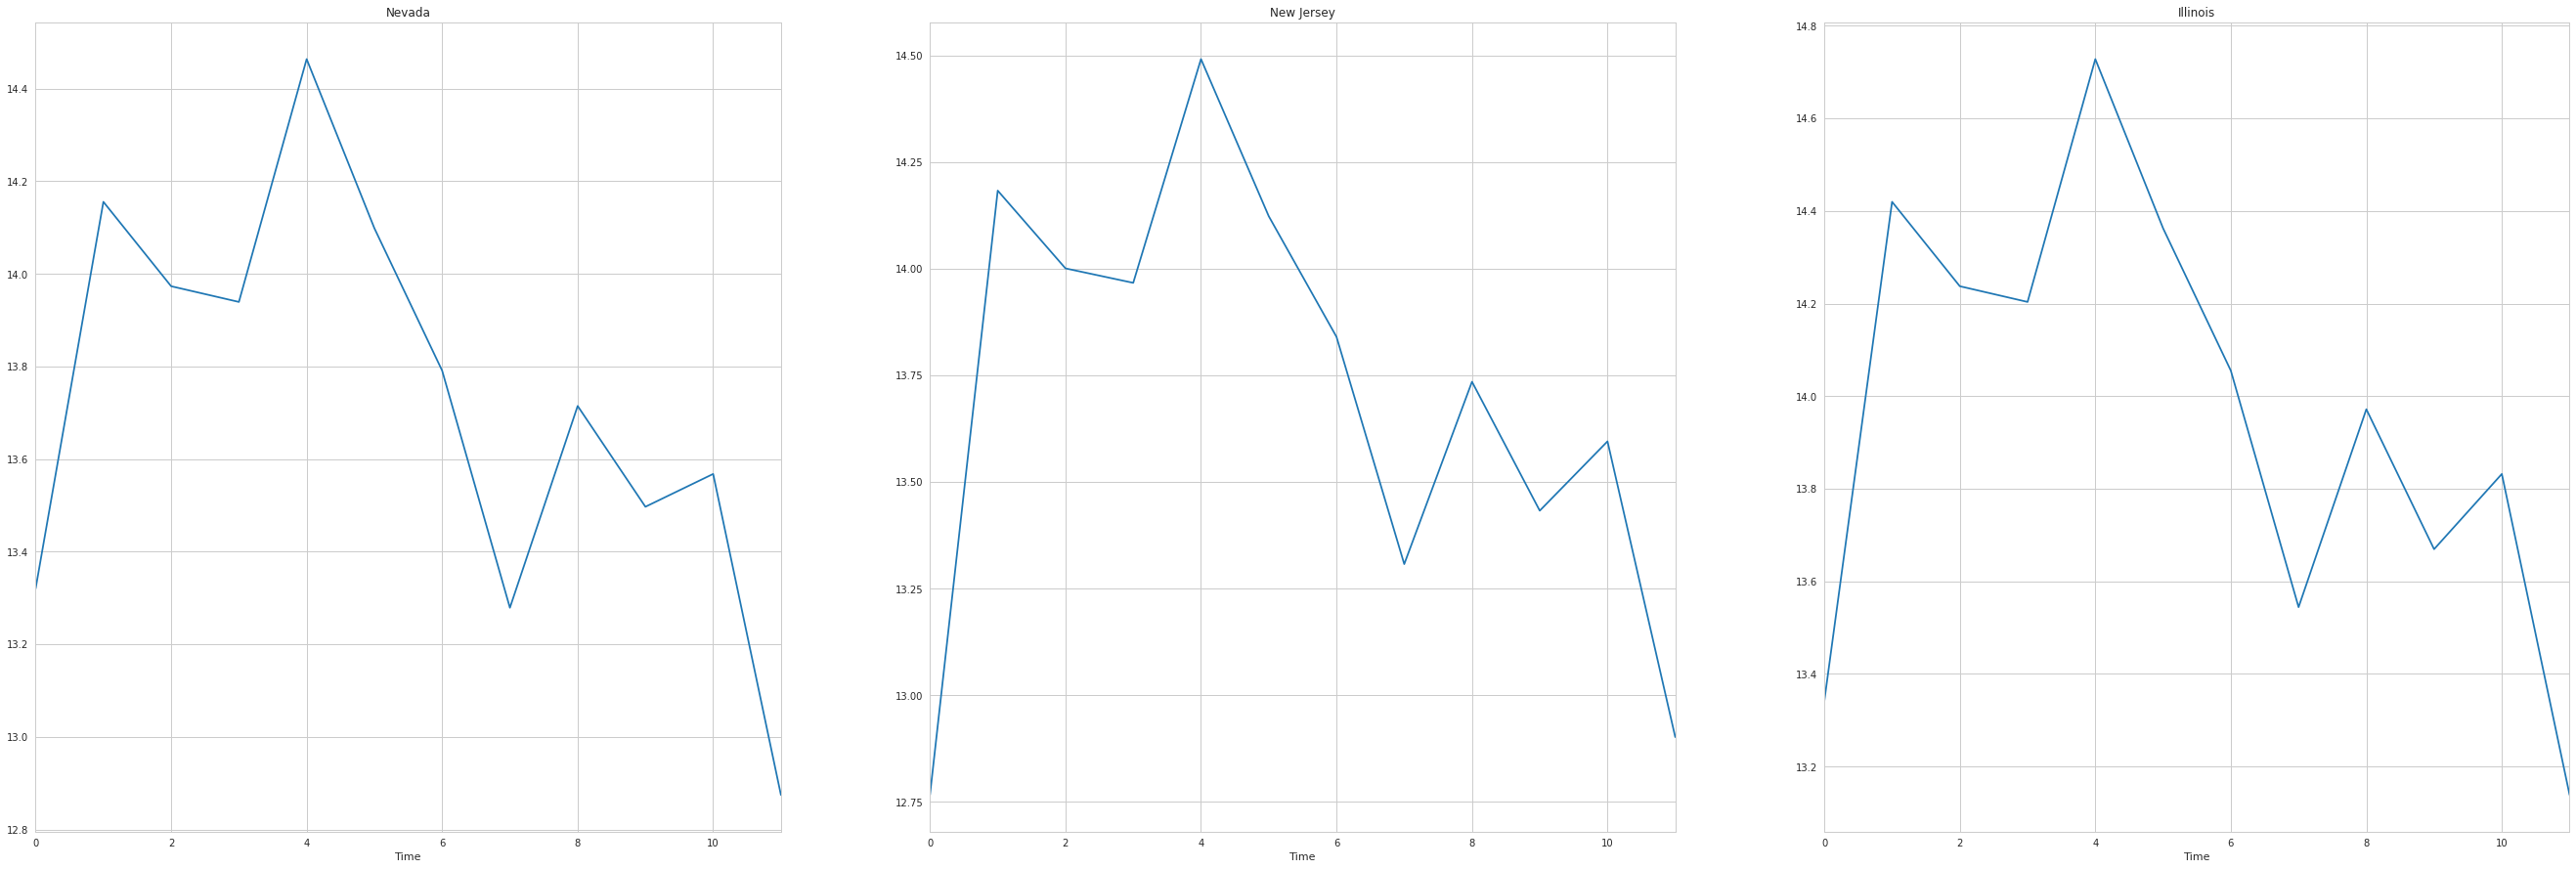

In [114]:
nonstationary_products = list(products_nonstationary.keys())

for i in range(12):
    begin = 3*i
    end = 3*(i+1)
    draw_log_time_series(final_trans, nonstationary_products[begin:end])

### Now analysing seasonal factors: Time decomposition

<Figure size 432x288 with 0 Axes>

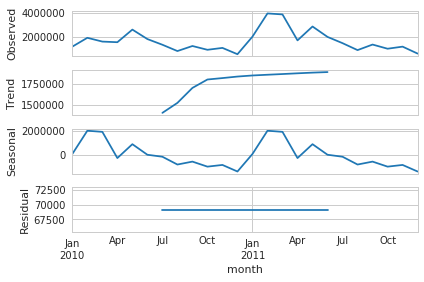

<Figure size 432x288 with 0 Axes>

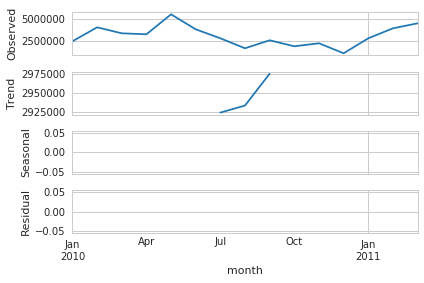

<Figure size 432x288 with 0 Axes>

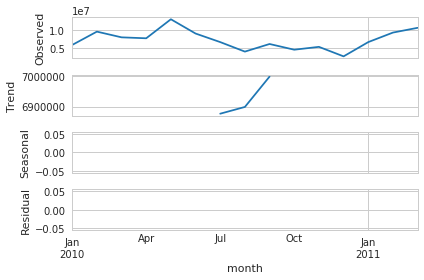

In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose

"""
Additive model by default

Frequency is 26, as our observation is weekly data
"""
nonstationary_products = list(products_nonstationary.keys())

prod_df = final_trans[final_trans.region == nonstationary_products[0]]
res = seasonal_decompose(prod_df['amount'], freq=12)
fig = plt.figure()  
fig = res.plot()
#plt.title(nonstationary_products[0])


prod_df = final_trans[final_trans.region == nonstationary_products[1]]
res = seasonal_decompose(prod_df['amount'])
fig = plt.figure()  
fig = res.plot()
#plt.title(nonstationary_products[1])


prod_df = final_trans[final_trans.region == nonstationary_products[2]]
res = seasonal_decompose(prod_df['amount'], freq=12)
fig = plt.figure() 
fig = res.plot() 
#plt.title(nonstationary_products[2])


### Stationary transformation

#### Draw ACF and PACF

The plot of Australia


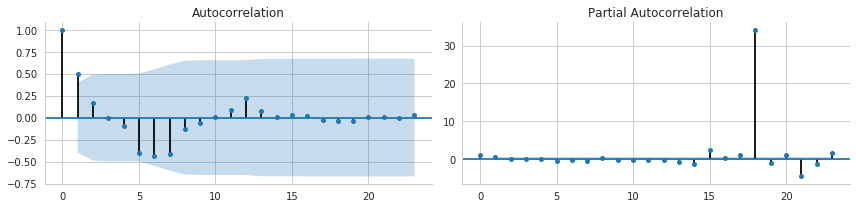

The plot of Southwest


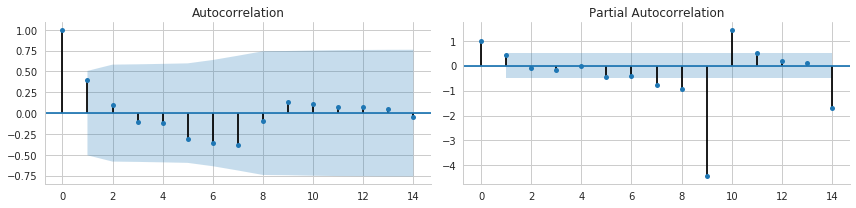

The plot of Southeast


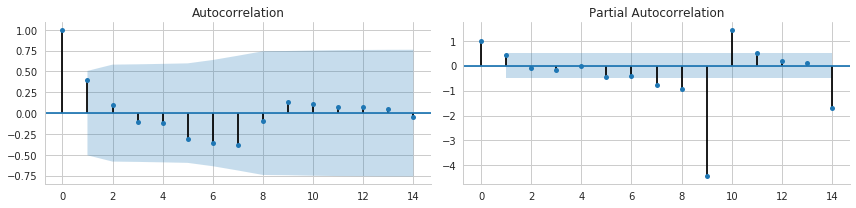

The plot of South Korea


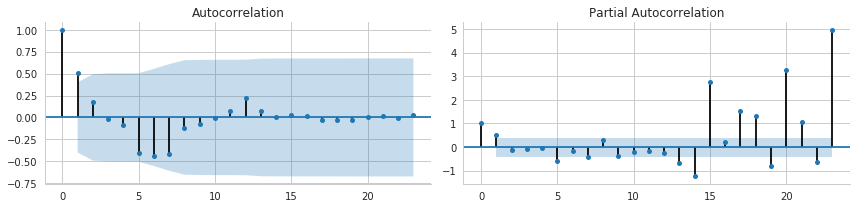

The plot of SA


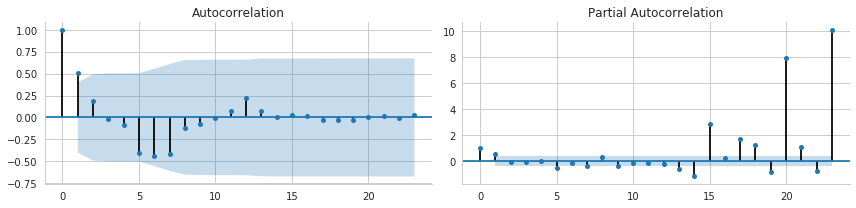

The plot of Other NA


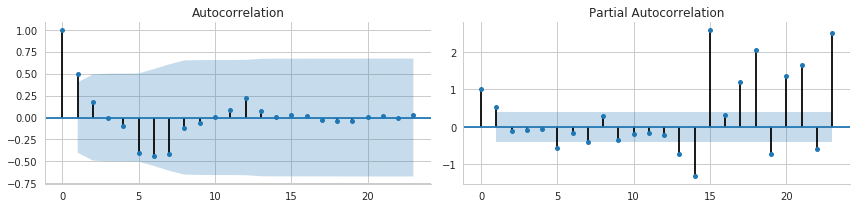

The plot of Other Asia


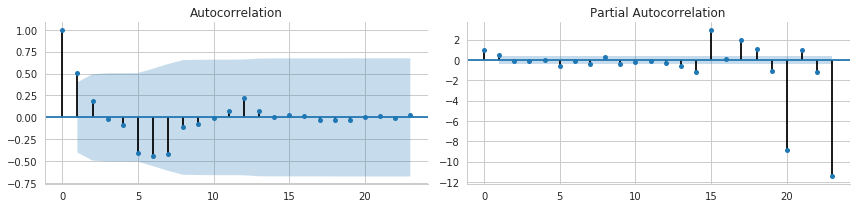

The plot of Northeast


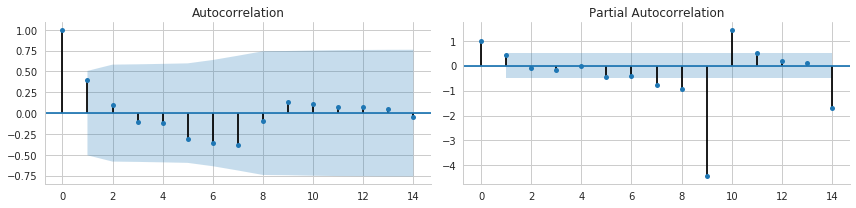

The plot of West


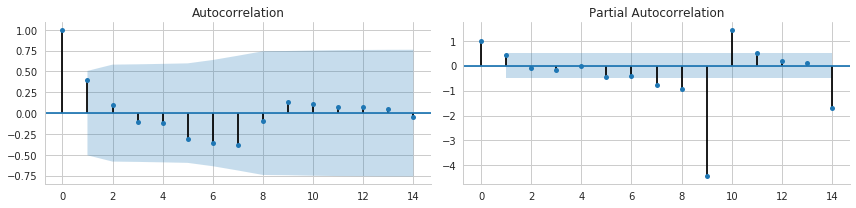

The plot of Midwest


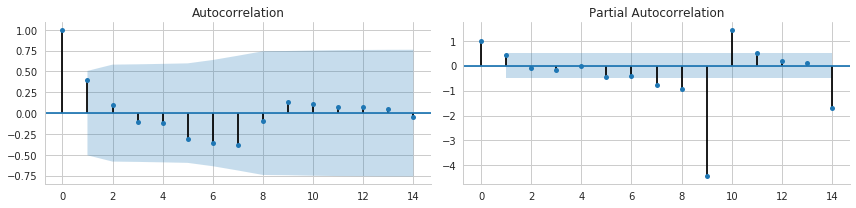

The plot of Middle East


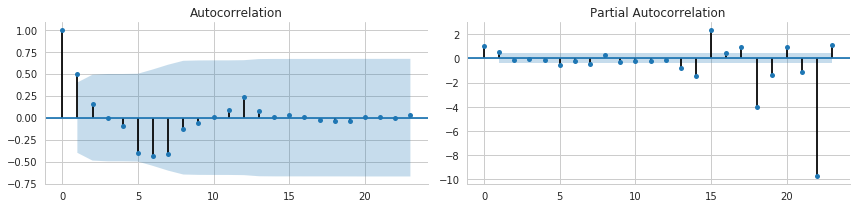

The plot of Mexico


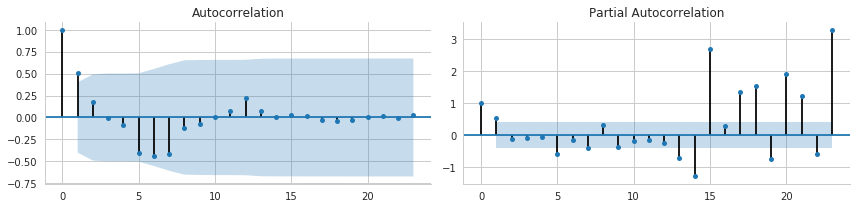

The plot of Japan


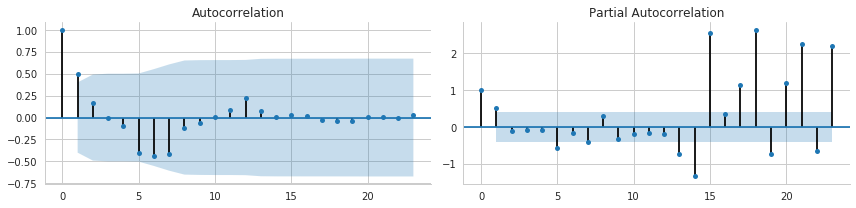

The plot of Europe


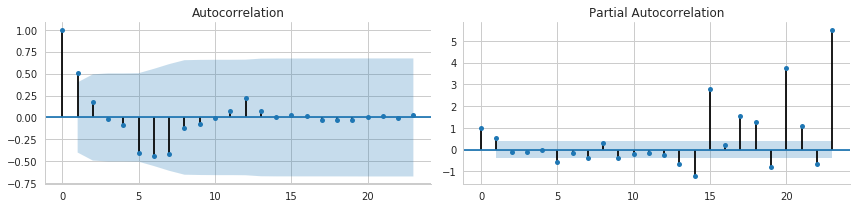

The plot of Canada


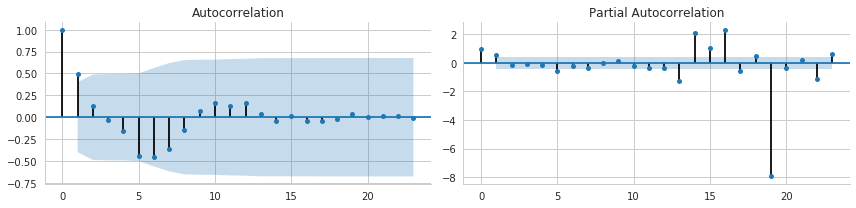

The plot of None


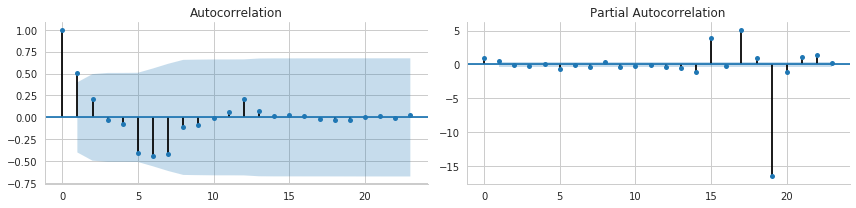

The plot of Other Midwest


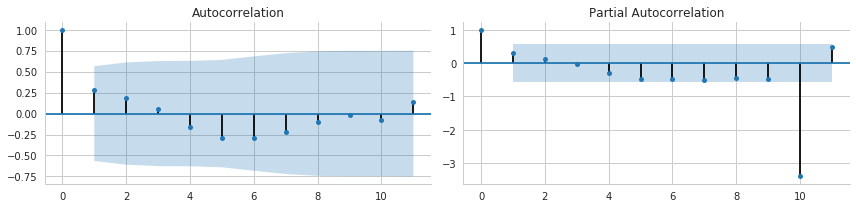

The plot of Ohio


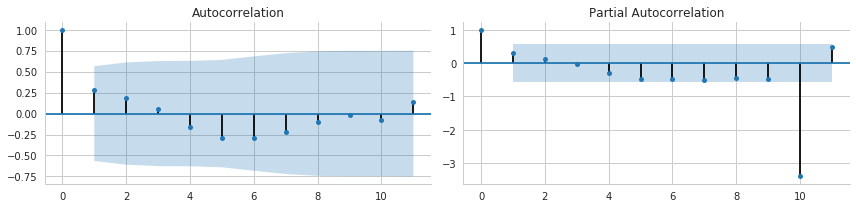

The plot of Other Northeast


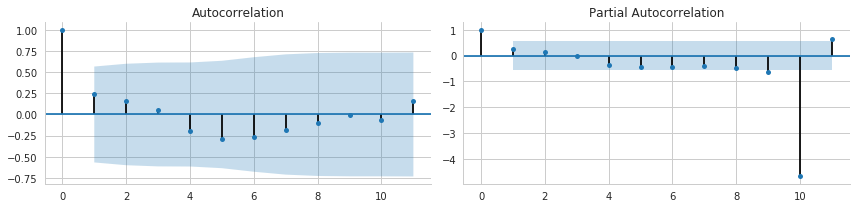

The plot of Oregon


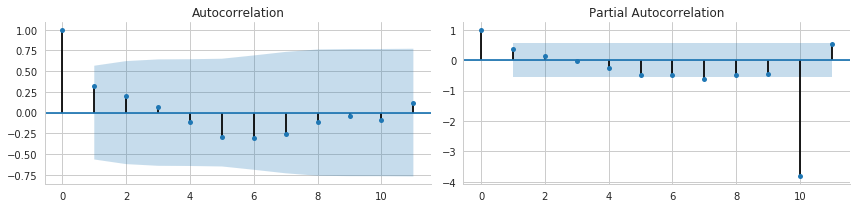

The plot of Other Southeast


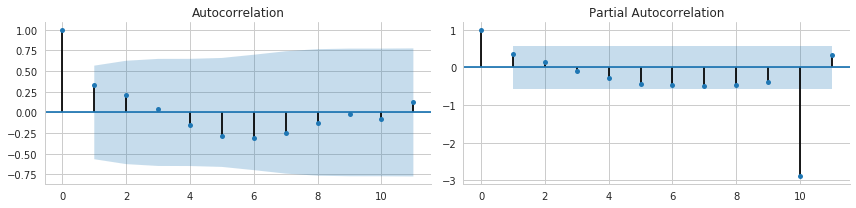

The plot of Texas


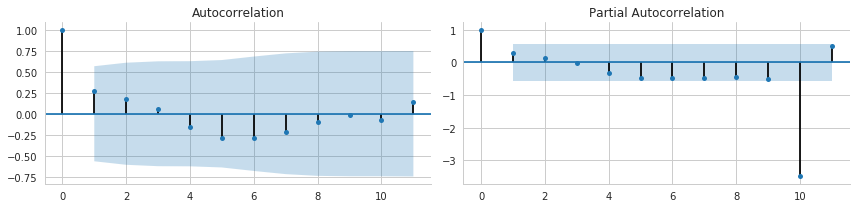

The plot of Other West


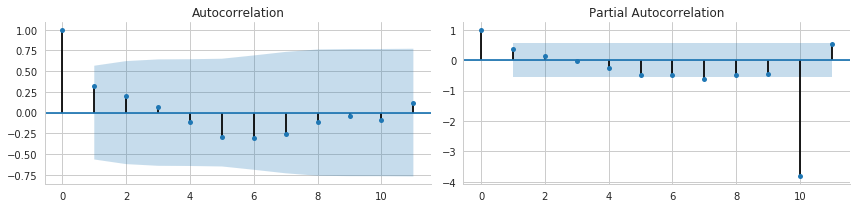

The plot of South Carolina


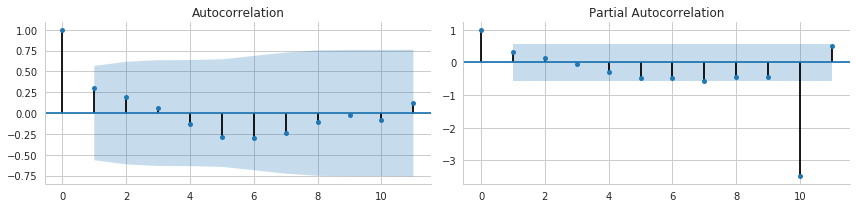

The plot of Other Southwest


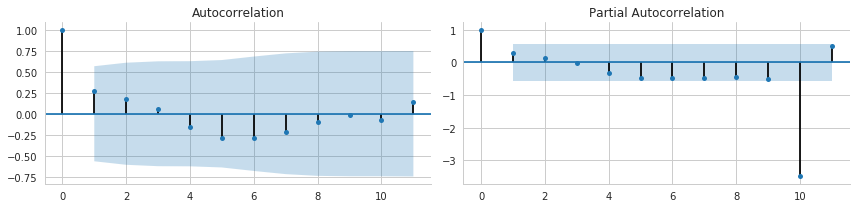

The plot of California


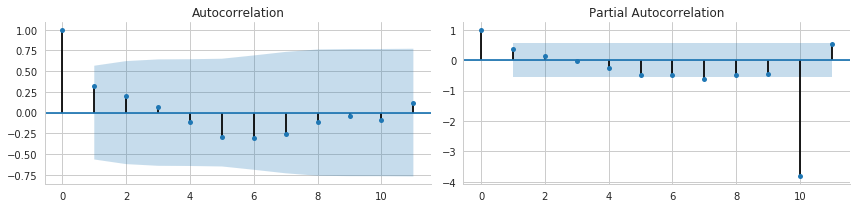

The plot of New Mexico


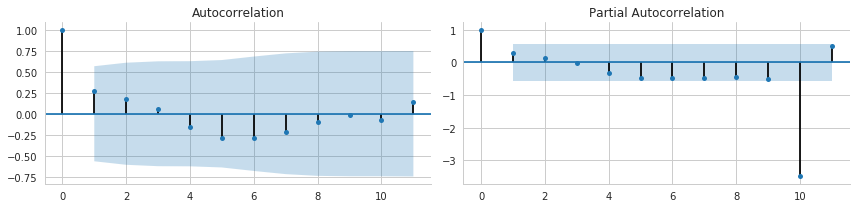

The plot of Arizona


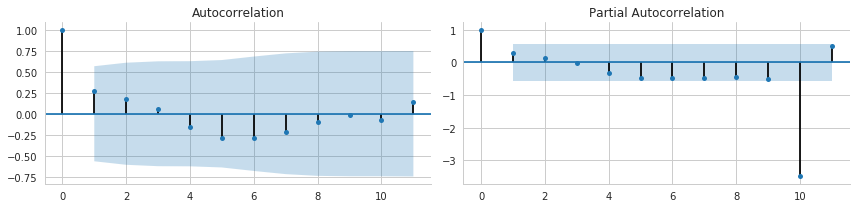

The plot of Connecticut


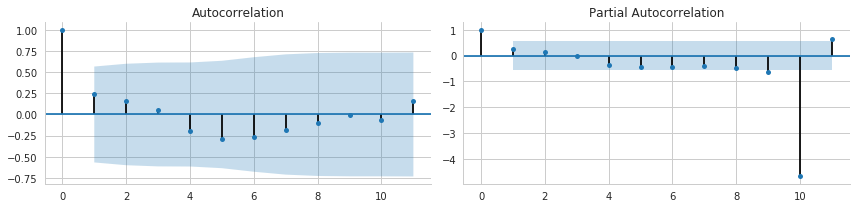

The plot of Florida


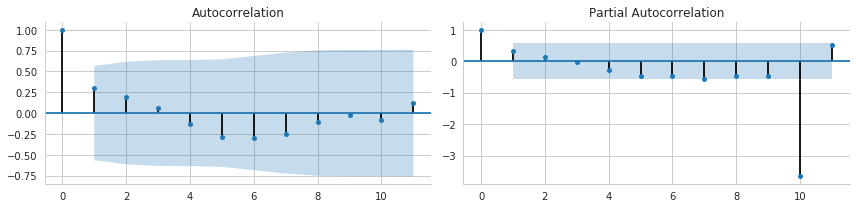

The plot of Georgia


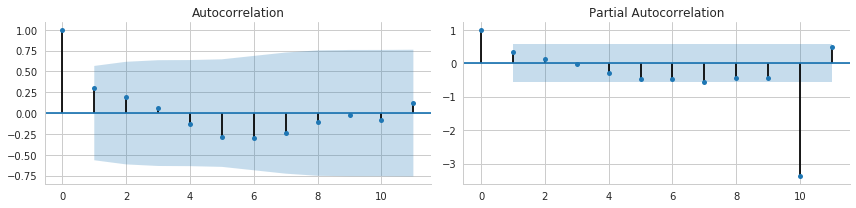

The plot of New York


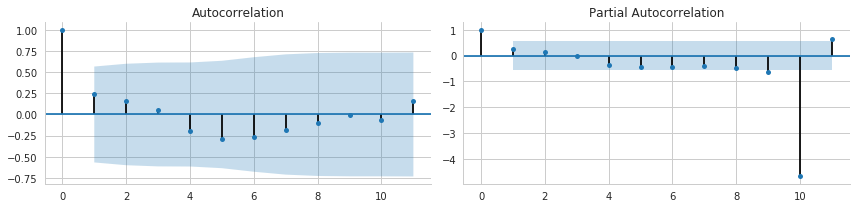

The plot of Michigan


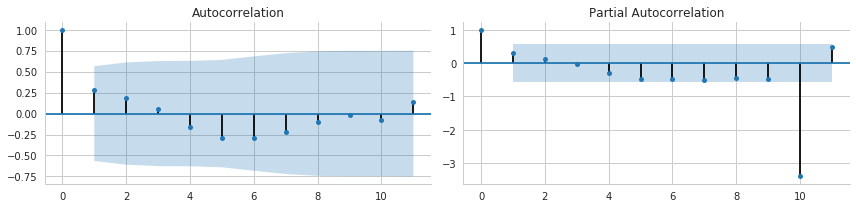

The plot of Nevada


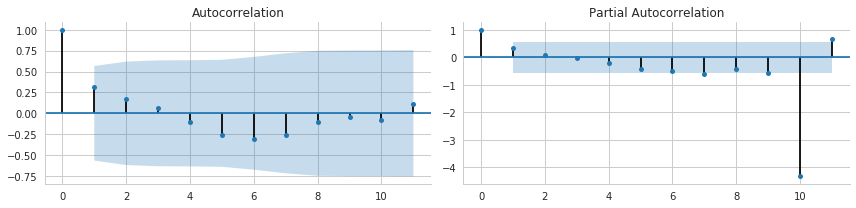

The plot of New Jersey


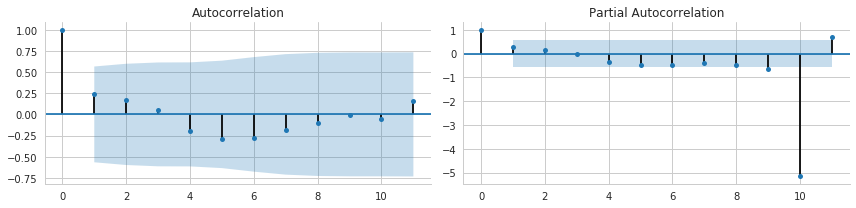

The plot of Illinois


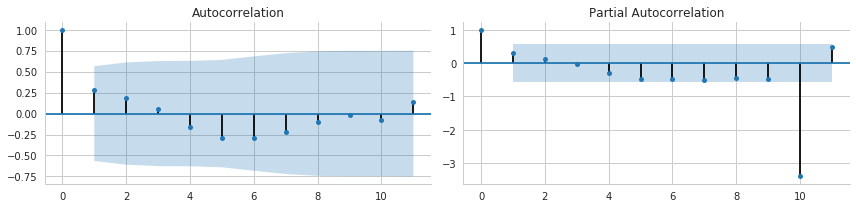

In [116]:
draw_acf_pacf(final_trans, nonstationary_products)

#### Differencing dataset.
We try differencing the dataset now. Recall that $$difference(t) = observation(t) - observation(t-1).$$


After first difference for all regions, second difference for the regions if they have more than one year data, and 12-th difference for the regions if they have 2 year data. we still have 4 regions with non-stationary data. But current result looks good enough. So let we use this dataset for modelling first!


In [206]:
def difference(final_trans, interval1,interval2):
    """
    Testing stationarity of differenced series.
    First difference for all time series data
    And do log 12 difference if time series have more than one year data
    """
    products = final_trans.region.unique()
    products_stationary = {} # collect stationary data: key is the name or product, value is p_value
    products_nonstationary = {} # collect non-stationary data 
    for prod in products:
        
        
        prod_df = pd.Series(final_trans[final_trans.region == prod]['amount'])
        
        prod_df = prod_df.diff(1).dropna()
        
        if len(prod_df) >10:  # if we have more than 1 year data
            prod_df = prod_df.diff(interval1).dropna()
        
        if len(prod_df) >20:  # if we have 2 year2 data
            prod_df = prod_df.diff(interval2).dropna()
            
            
            #new_data['month'] = final_trans[final_trans.region == prod]['amount'].index
            #new_data['diff_amount'] = prod_df
            
            
            #diff_final_trans = 
        
        
        
        """
        Dickey fuller test to check stationary
        """
        try:
            p_value = adfuller(prod_df)[1]
        except ValueError:
            print(prod_df)
             
            
        if p_value <0.05:  # we do at the 1% comcident level.
            products_stationary[prod] = p_value
            
            """
            Check by ACF and PACF after make stationary
            """
            #print("I am stationary !")
            #print(prod)
            #fig, ax = plt.subplots(1,2, figsize=(12,3))
            #sm.graphics.tsa.plot_acf(prod_df, lags=len(prod_df) -1, ax=ax[0])
            #sm.graphics.tsa.plot_pacf(prod_df, lags=len(prod_df) -1, ax=ax[1])
       
    
        else:
            products_nonstationary[prod] = p_value 
            """
            Check by ACF and PACF after make stationary
            """
            print(prod)
            fig, ax = plt.subplots(1,2, figsize=(12,3))
            sm.graphics.tsa.plot_acf(prod_df, lags=len(prod_df) -1, ax=ax[0])
            sm.graphics.tsa.plot_pacf(prod_df, lags=len(prod_df) -1, ax=ax[1])
        
    return products_stationary, products_nonstationary
        

Southwest
Other NA
Middle East
South Carolina
4 left non stationary regions 


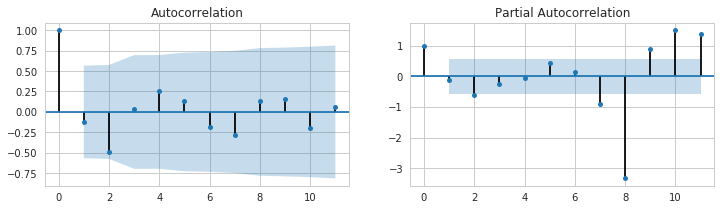

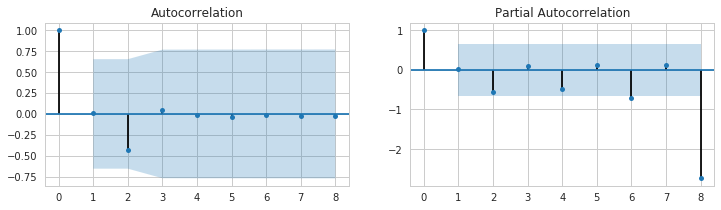

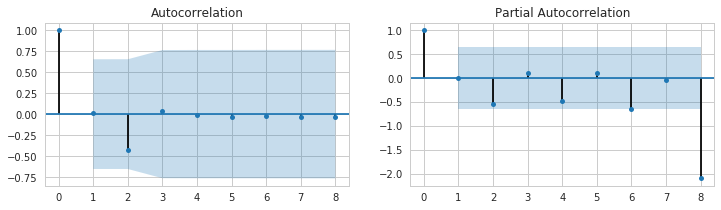

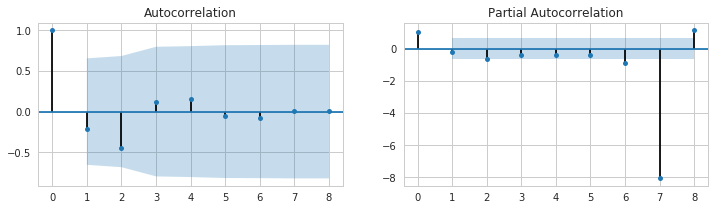

In [207]:
diff_first_stationary, diff_first_nonstationary = difference(final_trans, 2,12)
print("{} left non stationary regions ".format(len(diff_first_nonstationary)))

first difference is not useful . Thus we try others.

In [213]:
final_trans['region'].unique()

array(['Australia', 'Southwest', 'Southeast', 'South Korea', 'SA',
       'Other NA', 'Other Asia', 'Northeast', 'West', 'Midwest',
       'Middle East', 'Mexico', 'Japan', 'Europe', 'Canada', 'None',
       'Other Midwest', 'Ohio', 'Other Northeast', 'Oregon',
       'Other Southeast', 'Texas', 'Other West', 'South Carolina',
       'Other Southwest', 'California', 'New Mexico', 'Arizona',
       'Connecticut', 'Florida', 'Georgia', 'New York', 'Michigan',
       'Nevada', 'New Jersey', 'Illinois'], dtype=object)

In [214]:
final_trans = final_trans[['amount','region']]
final_trans['month'] = final_trans.index
final_trans = final_trans[['month','amount','region']]
final_trans.to_csv('nonstationary_amount_region.csv', header=False, index=False)

## Create useful one-dimensional Dataset 
Since input dataset for amazon forecasts need **one-dimensional**,i.e. only three columns in dataset: 
1. **timepoint**
2. **observations'value**: such as demand, sales, amount, also can be categorical dataset
3. **Item_id**: region in our case
4. **No header**